# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [1]:
# Import warnings

import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# Import the libraries you will be using for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.9.2
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [4]:
# Try loading one file

# df = pd.read_parquet('2023-1.parquet')
# df.info()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

In [5]:
# df.info()

In [6]:
# df.head()

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [7]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
# os.chdir('/Users/deepa.thangavelu/trip_records')
os.chdir('/content/Assignments/EDA/data_NYC_Taxi/trip_records')
# os.getcwd()
# Create a list of all the twelve files to read
# file_list = os.listdir()
file_list = [f for f in os.listdir(os.getcwd()) if not f.startswith('.DS_Store')]

# initialise an empty dataframe
df_sampled = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)
        sampled_df = pd.DataFrame()
        # Reading the current file
        df = pd.read_parquet(file_path)


        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        # Ensure 'tpep_pickup_datetime' is properly converted to datetime
        # df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])

        # Loop through dates and then loop through every hour of each date
        for date in df["tpep_pickup_datetime"].dt.date.unique():
            ## Filter data for the specific date
            daily_data = df[df["tpep_pickup_datetime"].dt.date == date]
            # Iterate through each hour of the selected date
            for hour in range(24):
                # Sample 5% of the hourly data randomly
                hourly_data = daily_data[daily_data["tpep_pickup_datetime"].dt.hour == hour]
                # add data of this hour to the dataframe
                if not hourly_data.empty:
                    sampled_hourly = hourly_data.sample(frac=0.05, random_state=42)
                    sampled_df = pd.concat([sampled_df, sampled_hourly], ignore_index=True)
        # Concatenate the sampled data of all the dates to a single dataframe
        df_sampled = pd.concat([df_sampled, sampled_df]) # adding data for this hour to the DF

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [10]:
# Store the df in csv/parquet
df_sampled.to_parquet('finalTripData.parquet', index=False)

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [11]:
# Load the new data file
# initialise an empty dataframe
dfLatestData = pd.read_parquet('finalTripData.parquet')


In [12]:
dfLatestData.shape

(1896400, 20)

In [13]:
dfLatestData.index

RangeIndex(start=0, stop=1896400, step=1)

In [14]:
dfLatestData.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
airport_fee                     float64
dtype: object

In [15]:
dfLatestData.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
1         2  2023-12-01 00:38:48   2023-12-01 01:01:55              NaN   
2         2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
3         2  2023-12-01 00:00:50   2023-12-01 00:14:37              NaN   
4         2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.99         1.0                  N           148            50   
1           4.79         NaN               None           231            61   
2           1.05         1.0                  N           161           161   
3           2.08         NaN               None           137           144   
4           0.40         1.0                  N            68            68   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1        23.30    1.0      0.5        5.66           0.0   
1             0        22.43    0.0      0.5        3.00           0.0   
2             1        10.70    1.0      0.5        3.14           0.0   
3             0        17.22    0.0      0.5        0.00           0.0   
4             1         5.10    1.0      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
0                    1.0         33.96                   2.5          0.0   
1                    1.0         29.43                   NaN          NaN   
2                    1.0         18.84                   2.5          0.0   
3                    1.0         21.22                   NaN          NaN   
4                    1.0         10.10                   2.5          0.0   

   airport_fee  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [16]:
dfLatestData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896400 entries, 0 to 1896399
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [17]:
dfLatestData.duplicated().any()

False

In [18]:
dfLatestData.isnull().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            64874
trip_distance                  0
RatecodeID                 64874
store_and_fwd_flag         64874
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge       64874
Airport_fee               213357
airport_fee              1747917
dtype: int64

In [19]:
dfLatestData.isnull().sum().sum()

2220770

In [20]:
dfLatestData.describe(include='all').T

count unique  top     freq  \
VendorID               1896400.0    NaN  NaN      NaN   
tpep_pickup_datetime     1896400    NaN  NaN      NaN   
tpep_dropoff_datetime    1896400    NaN  NaN      NaN   
passenger_count        1831526.0    NaN  NaN      NaN   
trip_distance          1896400.0    NaN  NaN      NaN   
RatecodeID             1831526.0    NaN  NaN      NaN   
store_and_fwd_flag       1831526      2    N  1820287   
PULocationID           1896400.0    NaN  NaN      NaN   
DOLocationID           1896400.0    NaN  NaN      NaN   
payment_type           1896400.0    NaN  NaN      NaN   
fare_amount            1896400.0    NaN  NaN      NaN   
extra                  1896400.0    NaN  NaN      NaN   
mta_tax                1896400.0    NaN  NaN      NaN   
tip_amount             1896400.0    NaN  NaN      NaN   
tolls_amount           1896400.0    NaN  NaN      NaN   
improvement_surcharge  1896400.0    NaN  NaN      NaN   
total_amount           1896400.0    NaN  NaN      NaN   
congestion_surcharge   1831526.0    NaN  NaN      NaN   
Airport_fee            1683043.0    NaN  NaN      NaN   
airport_fee             148483.0    NaN  NaN      NaN   

                                             mean                  min  \
VendorID                                 1.733026                  1.0   
tpep_pickup_datetime   2023-07-02 19:59:52.930795  2022-12-31 23:51:30   
tpep_dropoff_datetime  2023-07-02 20:17:18.919564  2022-12-31 23:56:06   
passenger_count                          1.369215                  0.0   
trip_distance                            3.858293                  0.0   
RatecodeID                               1.634694                  1.0   
store_and_fwd_flag                            NaN                  NaN   
PULocationID                           165.281376                  1.0   
DOLocationID                            164.05152                  1.0   
payment_type                             1.163817                  0.0   
fare_amount                              19.91935                  0.0   
extra                                    1.588018                 -2.5   
mta_tax                                   0.49528                 -0.5   
tip_amount                               3.547011                  0.0   
tolls_amount                             0.596534                  0.0   
improvement_surcharge                    0.998971                 -1.0   
total_amount                            28.981863                -5.75   
congestion_surcharge                     2.307524                 -2.5   
Airport_fee                              0.145885                -1.75   
airport_fee                              0.109036                -1.25   

                                              25%                         50%  \
VendorID                                      1.0                         2.0   
tpep_pickup_datetime   2023-04-02 16:10:08.750000  2023-06-27 15:44:22.500000   
tpep_dropoff_datetime  2023-04-02 16:27:43.500000         2023-06-27 16:01:15   
passenger_count                               1.0                         1.0   
trip_distance                                1.05                        1.79   
RatecodeID                                    1.0                         1.0   
store_and_fwd_flag                            NaN                         NaN   
PULocationID                                132.0                       162.0   
DOLocationID                                114.0                       162.0   
payment_type                                  1.0                         1.0   
fare_amount                                   9.3                        13.5   
extra                                         0.0                         1.0   
mta_tax                                       0.5                         0.5   
tip_amount                                    1.0                        2.85   
tolls_amount                                  0.0          

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [21]:
# Fix the index and drop any columns that are not needed
dfLatestData.reset_index(drop=True, inplace=True)


In [22]:
dfLatestData["airport_fee"].value_counts()

airport_fee
 0.00    135529
 1.25     12953
-1.25         1
Name: count, dtype: int64

In [23]:
dfLatestData["Airport_fee"].value_counts()

Airport_fee
 0.00    1535035
 1.75     121123
 1.25      26870
-1.75         11
-1.25          3
 1.00          1
Name: count, dtype: int64

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [24]:
# Combine the two airport fee columns
dfLatestData["airport_fee"] = dfLatestData["airport_fee"].fillna(0) + dfLatestData["Airport_fee"].fillna(0)

In [25]:
dfLatestData["airport_fee"].value_counts()

airport_fee
 0.00    1735438
 1.75     121123
 1.25      39823
-1.75         11
-1.25          4
 1.00          1
Name: count, dtype: int64

In [26]:
# Dropping the one of the columns after extracting the values from that column to the other airport fee column
dfLatestData.drop(columns=["Airport_fee"], inplace=True)

In [27]:
dfLatestData.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
1         2  2023-12-01 00:38:48   2023-12-01 01:01:55              NaN   
2         2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
3         2  2023-12-01 00:00:50   2023-12-01 00:14:37              NaN   
4         2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.99         1.0                  N           148            50   
1           4.79         NaN               None           231            61   
2           1.05         1.0                  N           161           161   
3           2.08         NaN               None           137           144   
4           0.40         1.0                  N            68            68   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1        23.30    1.0      0.5        5.66           0.0   
1             0        22.43    0.0      0.5        3.00           0.0   
2             1        10.70    1.0      0.5        3.14           0.0   
3             0        17.22    0.0      0.5        0.00           0.0   
4             1         5.10    1.0      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  
0                    1.0         33.96                   2.5          0.0  
1                    1.0         29.43                   NaN          0.0  
2                    1.0         18.84                   2.5          0.0  
3                    1.0         21.22                   NaN          0.0  
4                    1.0         10.10                   2.5          0.0

**2.1.4** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [28]:
# check where values of fare amount are negative
print('fare amount - min value ', dfLatestData["fare_amount"].min())
#print('fare amount - null sum : ', dfLatestData["fare_amount"].isnull().sum()) ## Fare amount contains positive amount only
print('**********************************')
print('extra - min value ',dfLatestData["extra"].min())
medianValue = dfLatestData["extra"].median()
dfLatestData["extra"] = dfLatestData["extra"].apply(lambda x : medianValue if x < 0 else x)  
#print('extra - null sum ',dfLatestData["extra"].isnull().sum())
print('**********************************')
print('mta_tax - min value ',dfLatestData["mta_tax"].min())
medianValue = dfLatestData["mta_tax"].median()
dfLatestData["mta_tax"] = dfLatestData["mta_tax"].apply(lambda x : medianValue if x < 0 else x)  
#print('mta_tax - min value ',dfLatestData["mta_tax"].isnull().sum())
print('**********************************')
print('improvement_surcharge - min value ',dfLatestData["improvement_surcharge"].min())
medianValue = dfLatestData["improvement_surcharge"].median()
dfLatestData["improvement_surcharge"] = dfLatestData["improvement_surcharge"].apply(lambda x : medianValue if x < 0 else x)  
#print('improvement_surcharge - null sum ',dfLatestData["improvement_surcharge"].isnull().sum())
print('**********************************')
print('airport_fee - min value ',dfLatestData["airport_fee"].min())
medianValue = dfLatestData["airport_fee"].median()
dfLatestData["airport_fee"] = dfLatestData["airport_fee"].apply(lambda x : medianValue if x < 0 else x)  
#print('airport_fee - null sum ',dfLatestData["airport_fee"].isnull().sum())
print('**********************************')
print('total_amount - min value ',dfLatestData["total_amount"].min())
medianValue = dfLatestData["total_amount"].median()
dfLatestData["total_amount"] = dfLatestData["total_amount"].apply(lambda x : medianValue if x < 0 else x)  
#print('total_amount - null sum ',dfLatestData["total_amount"].isnull().sum())
print('**********************************')
print('congestion_surcharge - min value ',dfLatestData["congestion_surcharge"].min())
medianValue = dfLatestData["congestion_surcharge"].median()
dfLatestData["congestion_surcharge"] = dfLatestData["congestion_surcharge"].apply(lambda x : medianValue if x < 0 else x)  
#print('congestion_surcharge - null sum ',dfLatestData["congestion_surcharge"].isnull().sum())
print('**********************************')
print('tip_amount - min value ',dfLatestData["tip_amount"].min())
#print('tip_amount - null sum ',dfLatestData["tip_amount"].isnull().sum())
print('**********************************')
print('tolls_amount - min value ',dfLatestData["tolls_amount"].min())
#print('tolls_amount - null sum ',dfLatestData["tolls_amount"].isnull().sum())
print('**********************************')
print('Negative value columns are -  extra, mta_tax, improvement_surcharge, airport_fee, total_amount and congestion_surcharge')
print('Fixing the above')
print('**********************************')
print('extra - min value ',dfLatestData["extra"].min())
print('**********************************')
print('mta_tax - min value ',dfLatestData["mta_tax"].min())
print('**********************************')
print('improvement_surcharge - min value ',dfLatestData["improvement_surcharge"].min())
print('**********************************')
print('airport_fee - min value ',dfLatestData["airport_fee"].min())
print('**********************************')
print('total_amount - min value ',dfLatestData["total_amount"].min())
print('**********************************')
print('congestion_surcharge - min value ',dfLatestData["congestion_surcharge"].min())
print('**********************************')
#dfLatestData = dfLatestData[dfLatestData["mta_tax"]>=0]
# dfLatestData["improvement_surcharge"].value_counts()
# dfLatestData = dfLatestData[dfLatestData["improvement_surcharge"]>=0]
# dfLatestData = dfLatestData[dfLatestData["airport_fee"]>=0]
# Find columns where at least one negative value exists


fare amount - min value  0.0
**********************************
extra - min value  -2.5
**********************************
mta_tax - min value  -0.5
**********************************
improvement_surcharge - min value  -1.0
**********************************
airport_fee - min value  -1.75
**********************************
total_amount - min value  -5.75
**********************************
congestion_surcharge - min value  -2.5
**********************************
tip_amount - min value  0.0
**********************************
tolls_amount - min value  0.0
**********************************
Negative value columns are -  extra, mta_tax, improvement_surcharge, airport_fee, total_amount and congestion_surcharge
Fixing the above
**********************************
extra - min value  0.0
**********************************
mta_tax - min value  0.0
**********************************
improvement_surcharge - min value  0.0
**********************************
airport_fee - min value  0.0
*************

Did you notice something different in the `RatecodeID` column for above records?

In [29]:
# Analyse RatecodeID for the negative fare amounts

dfLatestData["RatecodeID"].value_counts()

RatecodeID
1.0     1729259
2.0       71670
99.0      10472
5.0       10275
3.0        6124
4.0        3723
6.0           3
Name: count, dtype: int64

In [30]:
print("RatecodeId has valued other than actual values 1-6 ")

RatecodeId has valued other than actual values 1-6 


In [31]:
dfLatestData 

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
1               2  2023-12-01 00:38:48   2023-12-01 01:01:55              NaN   
2               2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
3               2  2023-12-01 00:00:50   2023-12-01 00:14:37              NaN   
4               2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
...           ...                  ...                   ...              ...   
1896395         2  2023-06-30 23:53:10   2023-07-01 00:05:55              1.0   
1896396         1  2023-06-30 23:22:42   2023-06-30 23:39:06              1.0   
1896397         1  2023-06-30 23:50:42   2023-07-01 00:20:00              2.0   
1896398         1  2023-06-30 23:05:31   2023-06-30 23:15:52              1.0   
1896399         2  2023-07-01 00:00:51   2023-07-01 00:24:19              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
0                 3.99         1.0                  N           148   
1                 4.79         NaN               None           231   
2                 1.05         1.0                  N           161   
3                 2.08         NaN               None           137   
4                 0.40         1.0                  N            68   
...                ...         ...                ...           ...   
1896395           2.63         1.0                  N           170   
1896396           0.00        99.0                  N            90   
1896397           5.40         1.0                  N            87   
1896398           1.00         1.0                  N            87   
1896399           5.04         1.0                  N           209   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
0                  50             1        23.30    1.0      0.5        5.66   
1                  61             0        22.43    0.0      0.5        3.00   
2                 161             1        10.70    1.0      0.5        3.14   
3                 144             0        17.22    0.0      0.5        0.00   
4                  68             1         5.10    1.0      0.5        0.00   
...               ...           ...          ...    ...      ...         ...   
1896395           143             1        14.20    1.0      0.5        4.80   
1896396           232             1        18.20    0.0      0.5        0.00   
1896397           161             1        32.40    3.5      0.5        2.00   
1896398           231             2        10.70    3.5      0.5        0.00   
1896399           225             1        25.40    1.0      0.5        4.56   

         tolls_amount  improvement_surcharge  total_amount  \
0                 0.0                    1.0         33.96   
1                 0.0                    1.0         29.43   
2                 0.0                    1.0         18.84   
3                 0.0                    1.0         21.22   
4                 0.0                    1.0         10.10   
...               ...                    ...           ...   
1896395           0.0                    1.0         24.00   
1896396           0.0                    1.0         19.70   
1896397           0.0                    1.0         39.40   
1896398           0.0                    1.0         15.70   
1896399           0.0                    1.0         34.96   

         congestion_surcharge  airport_fee  
0                         2.5          0.0  
1                         NaN          0.0  
2                         2.5          0.0  
3                         NaN          0.0  
4                         2.5          0.0  
...                       ...          ...  
1896395                   2.5          0.0  
1896396                   0.0          0.0  
1896397                   2.5          0.0  
1896398                   2

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [32]:
# Find the proportion of missing values in each column
dfLatestData.isnull().sum()
# dfLatestData["passenger_count"].value_counts()
# print("NUll of missing value for passengers", dfLatestData["passenger_count"].isnull().sum())
# dfLatestData['passenger_count'].fillna(dfLatestData['passenger_count'].median(), inplace=True)
# print("NUll of missing value for passengers", dfLatestData["passenger_count"].isnull().sum())

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          64874
trip_distance                0
RatecodeID               64874
store_and_fwd_flag       64874
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     64874
airport_fee                  0
dtype: int64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [33]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
dfLatestData['passenger_count'].fillna(dfLatestData['passenger_count'].median(), inplace=True)

In [34]:
dfLatestData['passenger_count'].value_counts()

passenger_count
1.0    1442098
2.0     277298
3.0      69034
4.0      38537
0.0      29681
5.0      23871
6.0      15860
8.0         11
9.0          5
7.0          5
Name: count, dtype: int64

Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [35]:
# Fix missing values in 'RatecodeID'
# dfLatestData["RatecodeID"].isnull().sum()
dfLatestData['RatecodeID'].fillna(dfLatestData['RatecodeID'].mode()[0], inplace=True)

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [36]:
# handle null values in congestion_surcharge
# dfLatestData["congestion_surcharge"].isnull().sum()
dfLatestData['congestion_surcharge'].fillna(dfLatestData['congestion_surcharge'].median(), inplace=True)


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [37]:
# Handle any remaining missing values
pd.set_option('future.no_silent_downcasting', True)
dfLatestData['store_and_fwd_flag'] = dfLatestData['store_and_fwd_flag'].replace('Y', 1)
dfLatestData['store_and_fwd_flag'] = dfLatestData['store_and_fwd_flag'].replace('N', 2)
dfLatestData['store_and_fwd_flag'].fillna(dfLatestData['store_and_fwd_flag'].mode()[0], inplace=True)
dfLatestData.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

In [38]:
dfLatestData = dfLatestData[dfLatestData['airport_fee'] >= 0]
dfLatestData.shape

(1896400, 19)

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

Number of outliers in trip_distance: 249302
Number of outliers in fare_amount: 197413
Number of outliers in extra: 34047
Number of outliers in mta_tax: 17871
Number of outliers in tip_amount: 145673
Number of outliers in tolls_amount: 153802
Number of outliers in total_amount: 218083
Number of outliers in congestion_surcharge: 140898
Number of outliers in airport_fee: 160947


KeyError: 'airport_fee'

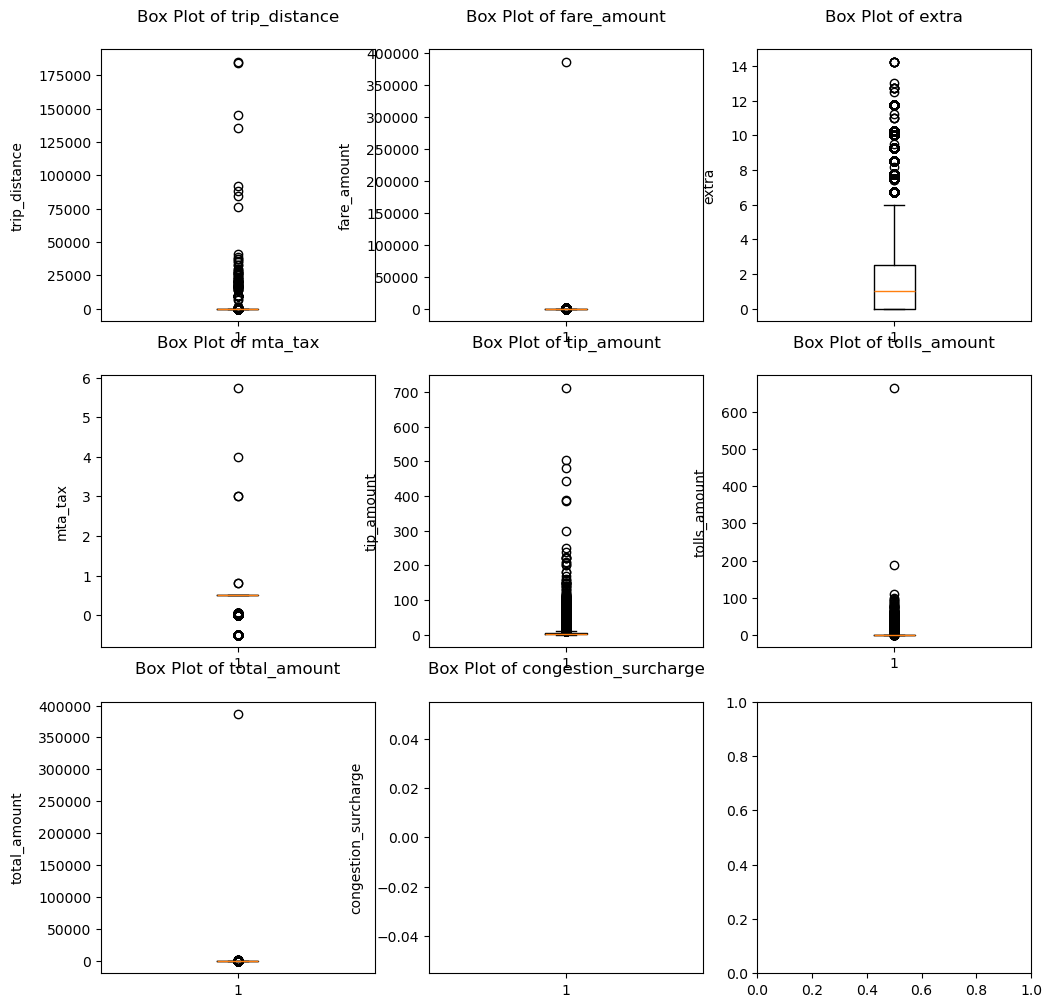

In [39]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Columns to check for outliers
numerical_columns = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'congestion_surcharge', 'airport_fee']

# Detecting outliers for each numerical column
outliers_dict = {}
for column in numerical_columns:
    outliers_dict[column] = detect_outliers_iqr(dfLatestData, column)

# Print the number of outliers detected in each column
for column, outliers in outliers_dict.items():
    print(f"Number of outliers in {column}: {len(outliers)}")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    axes[i].boxplot(df[column])
    axes[i].set_title(f'Box Plot of {column}', pad=20)
    axes[i].set_ylabel(column, labelpad=10)

plt.tight_layout()
plt.show()


**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [40]:
dfLatestData = dfLatestData[~(dfLatestData['passenger_count'] >6)] 
dfLatestData

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
1               2  2023-12-01 00:38:48   2023-12-01 01:01:55              1.0   
2               2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
3               2  2023-12-01 00:00:50   2023-12-01 00:14:37              1.0   
4               2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
...           ...                  ...                   ...              ...   
1896395         2  2023-06-30 23:53:10   2023-07-01 00:05:55              1.0   
1896396         1  2023-06-30 23:22:42   2023-06-30 23:39:06              1.0   
1896397         1  2023-06-30 23:50:42   2023-07-01 00:20:00              2.0   
1896398         1  2023-06-30 23:05:31   2023-06-30 23:15:52              1.0   
1896399         2  2023-07-01 00:00:51   2023-07-01 00:24:19              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
0                 3.99         1.0                  2           148   
1                 4.79         1.0                  2           231   
2                 1.05         1.0                  2           161   
3                 2.08         1.0                  2           137   
4                 0.40         1.0                  2            68   
...                ...         ...                ...           ...   
1896395           2.63         1.0                  2           170   
1896396           0.00        99.0                  2            90   
1896397           5.40         1.0                  2            87   
1896398           1.00         1.0                  2            87   
1896399           5.04         1.0                  2           209   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
0                  50             1        23.30    1.0      0.5        5.66   
1                  61             0        22.43    0.0      0.5        3.00   
2                 161             1        10.70    1.0      0.5        3.14   
3                 144             0        17.22    0.0      0.5        0.00   
4                  68             1         5.10    1.0      0.5        0.00   
...               ...           ...          ...    ...      ...         ...   
1896395           143             1        14.20    1.0      0.5        4.80   
1896396           232             1        18.20    0.0      0.5        0.00   
1896397           161             1        32.40    3.5      0.5        2.00   
1896398           231             2        10.70    3.5      0.5        0.00   
1896399           225             1        25.40    1.0      0.5        4.56   

         tolls_amount  improvement_surcharge  total_amount  \
0                 0.0                    1.0         33.96   
1                 0.0                    1.0         29.43   
2                 0.0                    1.0         18.84   
3                 0.0                    1.0         21.22   
4                 0.0                    1.0         10.10   
...               ...                    ...           ...   
1896395           0.0                    1.0         24.00   
1896396           0.0                    1.0         19.70   
1896397           0.0                    1.0         39.40   
1896398           0.0                    1.0         15.70   
1896399           0.0                    1.0         34.96   

         congestion_surcharge  airport_fee  
0                         2.5          0.0  
1                         2.5          0.0  
2                         2.5          0.0  
3                         2.5          0.0  
4                         2.5          0.0  
...                       ...          ...  
1896395                   2.5          0.0  
1896396                   0.0          0.0  
1896397                   2.5          0.0  
1896398                   2

In [41]:
dfLatestData = dfLatestData[~(dfLatestData['payment_type'] == 0)] 

In [42]:
dfLatestData

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
2               2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
4               2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
5               2  2023-12-01 00:57:08   2023-12-01 01:05:49              1.0   
6               2  2023-12-01 00:46:28   2023-12-01 00:59:29              2.0   
...           ...                  ...                   ...              ...   
1896395         2  2023-06-30 23:53:10   2023-07-01 00:05:55              1.0   
1896396         1  2023-06-30 23:22:42   2023-06-30 23:39:06              1.0   
1896397         1  2023-06-30 23:50:42   2023-07-01 00:20:00              2.0   
1896398         1  2023-06-30 23:05:31   2023-06-30 23:15:52              1.0   
1896399         2  2023-07-01 00:00:51   2023-07-01 00:24:19              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
0                 3.99         1.0                  2           148   
2                 1.05         1.0                  2           161   
4                 0.40         1.0                  2            68   
5                 1.66         1.0                  2           114   
6                 2.45         1.0                  2           164   
...                ...         ...                ...           ...   
1896395           2.63         1.0                  2           170   
1896396           0.00        99.0                  2            90   
1896397           5.40         1.0                  2            87   
1896398           1.00         1.0                  2            87   
1896399           5.04         1.0                  2           209   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
0                  50             1         23.3    1.0      0.5        5.66   
2                 161             1         10.7    1.0      0.5        3.14   
4                  68             1          5.1    1.0      0.5        0.00   
5                 186             1         10.7    1.0      0.5        3.14   
6                 232             1         14.9    1.0      0.5        1.00   
...               ...           ...          ...    ...      ...         ...   
1896395           143             1         14.2    1.0      0.5        4.80   
1896396           232             1         18.2    0.0      0.5        0.00   
1896397           161             1         32.4    3.5      0.5        2.00   
1896398           231             2         10.7    3.5      0.5        0.00   
1896399           225             1         25.4    1.0      0.5        4.56   

         tolls_amount  improvement_surcharge  total_amount  \
0                 0.0                    1.0         33.96   
2                 0.0                    1.0         18.84   
4                 0.0                    1.0         10.10   
5                 0.0                    1.0         18.84   
6                 0.0                    1.0         20.90   
...               ...                    ...           ...   
1896395           0.0                    1.0         24.00   
1896396           0.0                    1.0         19.70   
1896397           0.0                    1.0         39.40   
1896398           0.0                    1.0         15.70   
1896399           0.0                    1.0         34.96   

         congestion_surcharge  airport_fee  
0                         2.5          0.0  
2                         2.5          0.0  
4                         2.5          0.0  
5                         2.5          0.0  
6                         2.5          0.0  
...                       ...          ...  
1896395                   2.5          0.0  
1896396                   0.0          0.0  
1896397                   2.5          0.0  
1896398                   2

In [43]:
# Continue with outlier handling

dfLatestData1 = dfLatestData[(dfLatestData['trip_distance'] == 0) & (dfLatestData['fare_amount'] > 0) ]

dfLatestData1

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
7               2  2023-12-01 00:36:28   2023-12-01 00:36:34              1.0   
219             2  2023-12-01 01:08:22   2023-12-01 01:08:56              1.0   
227             1  2023-12-01 01:03:11   2023-12-01 01:03:15              1.0   
246             1  2023-12-01 01:08:05   2023-12-01 01:14:02              1.0   
274             1  2023-12-01 01:33:00   2023-12-01 01:33:35              1.0   
...           ...                  ...                   ...              ...   
1895879         1  2023-06-30 21:28:49   2023-06-30 22:04:59              1.0   
1895952         2  2023-06-30 22:36:31   2023-06-30 22:36:34              2.0   
1896172         1  2023-06-30 22:29:55   2023-06-30 22:30:20              0.0   
1896277         2  2023-06-30 23:03:15   2023-06-30 23:10:06              5.0   
1896396         1  2023-06-30 23:22:42   2023-06-30 23:39:06              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
7                  0.0         5.0                  2           170   
219                0.0         1.0                  2           161   
227                0.0         1.0                  2           161   
246                0.0         1.0                  2           140   
274                0.0         1.0                  2            63   
...                ...         ...                ...           ...   
1895879            0.0         1.0                  2           254   
1895952            0.0         5.0                  2           228   
1896172            0.0         5.0                  1           170   
1896277            0.0         1.0                  2           140   
1896396            0.0        99.0                  2            90   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
7                 170             1         11.0    0.0      0.0        2.90   
219               161             4          3.0    1.0      0.5        0.00   
227               161             2          3.0    3.5      0.5        0.00   
246               262             1          4.4    3.5      0.5        2.00   
274                63             3          3.0    1.0      0.5        0.00   
...               ...           ...          ...    ...      ...         ...   
1895879           264             1         29.2    0.0      0.5        0.00   
1895952           228             1         45.0    0.0      0.5        0.01   
1896172           170             1         19.0    0.0      0.0        4.00   
1896277           262             1          7.2    1.0      0.5        1.22   
1896396           232             1         18.2    0.0      0.5        0.00   

         tolls_amount  improvement_surcharge  total_amount  \
7                0.00                    1.0         17.40   
219              0.00                    1.0          8.00   
227              0.00                    1.0          8.00   
246              0.00                    1.0         11.40   
274              0.00                    1.0          5.50   
...               ...                    ...           ...   
1895879          6.55                    1.0         37.25   
1895952          0.00                    1.0         46.51   
1896172          0.00                    1.0         24.00   
1896277          0.00                    1.0         13.42   
1896396          0.00                    1.0         19.70   

         congestion_surcharge  airport_fee  
7                         2.5          0.0  
219                       2.5          0.0  
227                       2.5          0.0  
246                       2.5          0.0  
274                       0.0          0.0  
...                       ...          ...  
1895879                   0.0          0.0  
1895952                   0.0          0.0  
1896172                   0.0          0.0  
1896277                   2

In [44]:
dfLatestData2 = dfLatestData[ (dfLatestData['fare_amount'] > 300) ]
dfLatestData2

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
15921           1  2023-12-03 16:42:58   2023-12-03 18:56:03              1.0   
39226           2  2023-12-07 17:14:33   2023-12-07 18:44:18              1.0   
41492           2  2023-12-07 23:39:43   2023-12-07 23:39:59              1.0   
45565           2  2023-12-08 17:40:34   2023-12-08 19:18:35              1.0   
70363           2  2023-12-12 18:41:17   2023-12-12 20:35:41              1.0   
...           ...                  ...                   ...              ...   
1849262         2  2023-06-22 01:11:52   2023-06-22 02:30:58              1.0   
1864948         1  2023-06-24 19:41:42   2023-06-24 19:43:18              1.0   
1870643         2  2023-06-25 22:53:31   2023-06-26 00:12:15              1.0   
1890581         2  2023-06-29 20:56:07   2023-06-29 20:56:15              1.0   
1890966         2  2023-06-29 21:29:31   2023-06-29 23:01:46              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
15921           101.90         1.0                  2           265   
39226            49.79         4.0                  2           132   
41492             0.00         5.0                  2           265   
45565            54.45         4.0                  2           162   
70363            55.29         4.0                  2           148   
...                ...         ...                ...           ...   
1849262          64.32         5.0                  2           216   
1864948           0.00         5.0                  2           164   
1870643          59.00         5.0                  2           132   
1890581           0.00         5.0                  2           265   
1890966          73.23         4.0                  2           132   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
15921             146             1        372.6    0.0      0.5        0.00   
39226             265             1        339.7    2.5      0.5        0.00   
41492             265             2        319.0    0.0      0.0        0.00   
45565             265             1        332.7    2.5      0.5      103.84   
70363             265             1        344.6    2.5      0.0       25.00   
...               ...           ...          ...    ...      ...         ...   
1849262           265             1        350.0    0.0      0.0       15.00   
1864948           164             1        400.0    0.0      0.0        0.00   
1870643           265             1        400.0    0.0      0.0        0.00   
1890581           265             1        350.0    0.0      0.0       70.20   
1890966           265             1        446.1    1.0      0.5        0.00   

         tolls_amount  improvement_surcharge  total_amount  \
15921            6.94                    1.0        381.04   
39226            0.00                    1.0        345.45   
41492            0.00                    1.0        320.00   
45565            6.94                    1.0        449.98   
70363            0.00                    1.0        373.10   
...               ...                    ...           ...   
1849262         19.30                    1.0        385.30   
1864948          0.00                    1.0        401.00   
1870643          0.00                    1.0        402.75   
1890581          0.00                    1.0        421.20   
1890966          6.55                    1.0        456.90   

         congestion_surcharge  airport_fee  
15921                     0.0         0.00  
39226                     0.0         1.75  
41492                     0.0         0.00  
45565                     2.5         0.00  
70363                     0.0         0.00  
...                       ...          ...  
1849262                   0.0         0.00  
1864948                   0.0         0.00  
1870643                   0.0         1.75  
1890581                   0

In [45]:
# Do any columns need standardising?
dfLatestData = dfLatestData[~(dfLatestData['RatecodeID'] >6)] 
dfLatestData

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
2               2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
4               2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
5               2  2023-12-01 00:57:08   2023-12-01 01:05:49              1.0   
6               2  2023-12-01 00:46:28   2023-12-01 00:59:29              2.0   
...           ...                  ...                   ...              ...   
1896394         2  2023-06-30 23:19:44   2023-06-30 23:32:53              1.0   
1896395         2  2023-06-30 23:53:10   2023-07-01 00:05:55              1.0   
1896397         1  2023-06-30 23:50:42   2023-07-01 00:20:00              2.0   
1896398         1  2023-06-30 23:05:31   2023-06-30 23:15:52              1.0   
1896399         2  2023-07-01 00:00:51   2023-07-01 00:24:19              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
0                 3.99         1.0                  2           148   
2                 1.05         1.0                  2           161   
4                 0.40         1.0                  2            68   
5                 1.66         1.0                  2           114   
6                 2.45         1.0                  2           164   
...                ...         ...                ...           ...   
1896394           2.03         1.0                  2            79   
1896395           2.63         1.0                  2           170   
1896397           5.40         1.0                  2            87   
1896398           1.00         1.0                  2            87   
1896399           5.04         1.0                  2           209   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
0                  50             1         23.3    1.0      0.5        5.66   
2                 161             1         10.7    1.0      0.5        3.14   
4                  68             1          5.1    1.0      0.5        0.00   
5                 186             1         10.7    1.0      0.5        3.14   
6                 232             1         14.9    1.0      0.5        1.00   
...               ...           ...          ...    ...      ...         ...   
1896394           170             1         14.2    1.0      0.5        3.84   
1896395           143             1         14.2    1.0      0.5        4.80   
1896397           161             1         32.4    3.5      0.5        2.00   
1896398           231             2         10.7    3.5      0.5        0.00   
1896399           225             1         25.4    1.0      0.5        4.56   

         tolls_amount  improvement_surcharge  total_amount  \
0                 0.0                    1.0         33.96   
2                 0.0                    1.0         18.84   
4                 0.0                    1.0         10.10   
5                 0.0                    1.0         18.84   
6                 0.0                    1.0         20.90   
...               ...                    ...           ...   
1896394           0.0                    1.0         23.04   
1896395           0.0                    1.0         24.00   
1896397           0.0                    1.0         39.40   
1896398           0.0                    1.0         15.70   
1896399           0.0                    1.0         34.96   

         congestion_surcharge  airport_fee  
0                         2.5          0.0  
2                         2.5          0.0  
4                         2.5          0.0  
5                         2.5          0.0  
6                         2.5          0.0  
...                       ...          ...  
1896394                   2.5          0.0  
1896395                   2.5          0.0  
1896397                   2.5          0.0  
1896398                   2

In [46]:
dfLatestData.RatecodeID.value_counts()

RatecodeID
1.0    1729259
2.0      71670
5.0      10254
3.0       6124
4.0       3723
6.0          3
Name: count, dtype: int64

In [47]:
dfLatestData.RatecodeID.isnull().sum()

0

In [48]:
dfLatestData["trip_duration"] = round((dfLatestData["tpep_dropoff_datetime"]-dfLatestData["tpep_pickup_datetime"]).dt.total_seconds()/60,2)
dfLatestData

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
2               2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
4               2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
5               2  2023-12-01 00:57:08   2023-12-01 01:05:49              1.0   
6               2  2023-12-01 00:46:28   2023-12-01 00:59:29              2.0   
...           ...                  ...                   ...              ...   
1896394         2  2023-06-30 23:19:44   2023-06-30 23:32:53              1.0   
1896395         2  2023-06-30 23:53:10   2023-07-01 00:05:55              1.0   
1896397         1  2023-06-30 23:50:42   2023-07-01 00:20:00              2.0   
1896398         1  2023-06-30 23:05:31   2023-06-30 23:15:52              1.0   
1896399         2  2023-07-01 00:00:51   2023-07-01 00:24:19              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
0                 3.99         1.0                  2           148   
2                 1.05         1.0                  2           161   
4                 0.40         1.0                  2            68   
5                 1.66         1.0                  2           114   
6                 2.45         1.0                  2           164   
...                ...         ...                ...           ...   
1896394           2.03         1.0                  2            79   
1896395           2.63         1.0                  2           170   
1896397           5.40         1.0                  2            87   
1896398           1.00         1.0                  2            87   
1896399           5.04         1.0                  2           209   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
0                  50             1         23.3    1.0      0.5        5.66   
2                 161             1         10.7    1.0      0.5        3.14   
4                  68             1          5.1    1.0      0.5        0.00   
5                 186             1         10.7    1.0      0.5        3.14   
6                 232             1         14.9    1.0      0.5        1.00   
...               ...           ...          ...    ...      ...         ...   
1896394           170             1         14.2    1.0      0.5        3.84   
1896395           143             1         14.2    1.0      0.5        4.80   
1896397           161             1         32.4    3.5      0.5        2.00   
1896398           231             2         10.7    3.5      0.5        0.00   
1896399           225             1         25.4    1.0      0.5        4.56   

         tolls_amount  improvement_surcharge  total_amount  \
0                 0.0                    1.0         33.96   
2                 0.0                    1.0         18.84   
4                 0.0                    1.0         10.10   
5                 0.0                    1.0         18.84   
6                 0.0                    1.0         20.90   
...               ...                    ...           ...   
1896394           0.0                    1.0         23.04   
1896395           0.0                    1.0         24.00   
1896397           0.0                    1.0         39.40   
1896398           0.0                    1.0         15.70   
1896399           0.0                    1.0         34.96   

         congestion_surcharge  airport_fee  trip_duration  
0                         2.5          0.0          22.35  
2                         2.5          0.0          10.63  
4                         2.5          0.0           3.17  
5                         2.5          0.0           8.68  
6                         2.5          0.0          13.02  
...                       ...          ...            ...  
1896394                   2.5          0.0          13.15

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [49]:
dfLatestData.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'trip_duration']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:  <b> Categorical </b>
* `tpep_pickup_datetime`: <b> Numerical </b>
* `tpep_dropoff_datetime`: <b> Numerical </b>
* `passenger_count`: <b> Categorical </b>
* `trip_distance`: <b> Numerical </b>
* `RatecodeID`: <b> Categorical </b>
* `PULocationID`: <b> Categorical </b>
* `DOLocationID`: <b> Categorical </b>
* `payment_type`: <b> Categorical </b>
* `pickup_hour`: <b> Numerical </b>
* `trip_duration`: <b> Numerical </b>


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount` : <b> Numerical </b>
* `extra` :<b> Numerical </b>
* `mta_tax` :<b> Categorical </b>
* `tip_amount` :<b> Numerical </b>
* `tolls_amount` :<b> Categorical </b>
* `improvement_surcharge` :<b> Numerical </b>
* `total_amount` :<b> Numerical </b>
* `congestion_surcharge` :<b> Numerical </b>
* `airport_fee` :<b> Categorical </b>

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

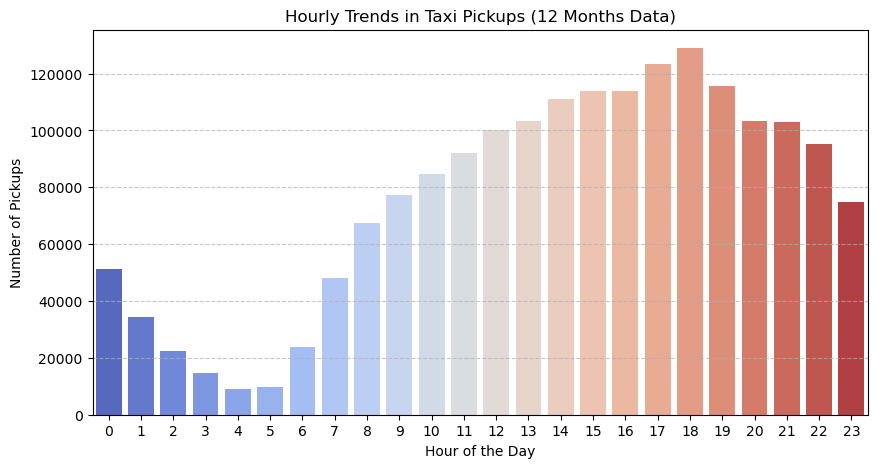

In [50]:
# Find and show the hourly trends in taxi pickups

# Extract hour and month from datetime
dfLatestData["hour"] = dfLatestData["tpep_pickup_datetime"].dt.hour
dfLatestData["month"] = dfLatestData["tpep_pickup_datetime"].dt.month

# Group by hour and count pickups
hourly_pickups = dfLatestData.groupby("hour")["tpep_pickup_datetime"].count()

plt.figure(figsize=(10,5))
sns.barplot(x=hourly_pickups.index, y=hourly_pickups.values, palette="coolwarm")

# Formatting
plt.title("Hourly Trends in Taxi Pickups (12 Months Data)")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Pickups")
plt.xticks(range(24))  # Show all hours from 0 to 23
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()



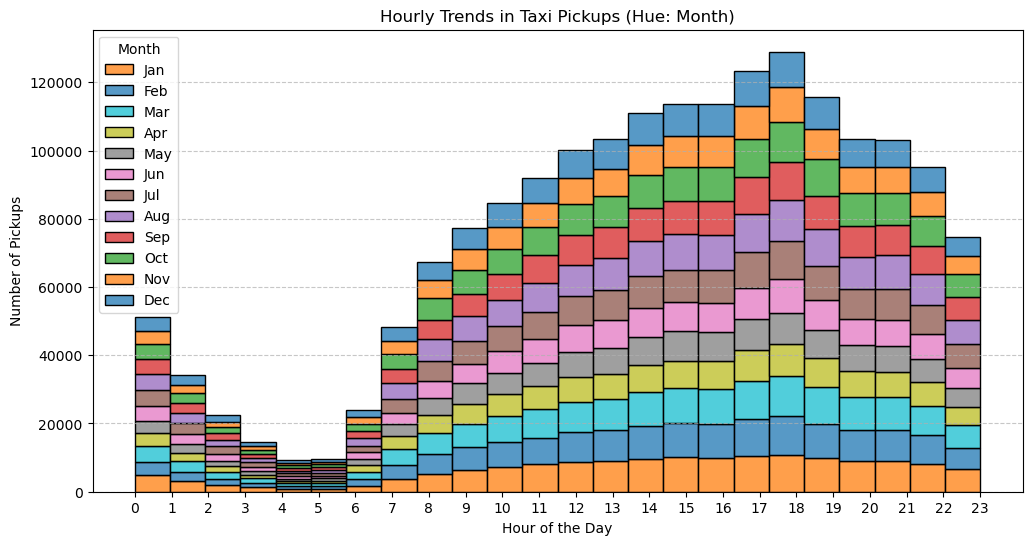

In [51]:
plt.figure(figsize=(12,6))

# Plot hourly pickup trends with hue for month
sns.histplot(data=dfLatestData, x="hour", hue="month", multiple="stack", bins=24, palette="tab10")

# Formatting
plt.title("Hourly Trends in Taxi Pickups (Hue: Month)")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Pickups")
plt.xticks(range(24))  # Show all hours from 0 to 23
plt.legend(title="Month", labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


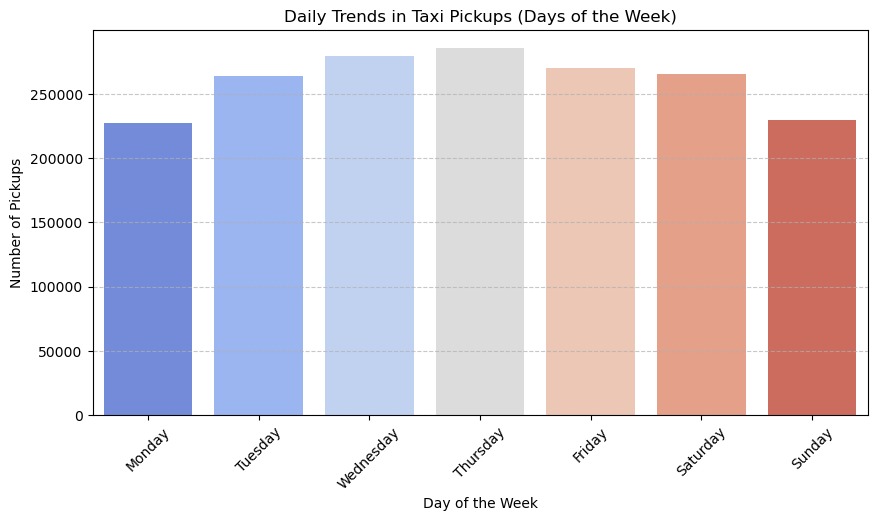

In [52]:
# Find and show the daily trends in taxi pickups (days of the week)


# Extract day of the week (0 = Monday, 6 = Sunday)
dfLatestData["day_of_week"] = dfLatestData["tpep_pickup_datetime"].dt.dayofweek

# Group by day of the week and count pickups
daily_pickups = dfLatestData.groupby("day_of_week")["tpep_pickup_datetime"].count().reset_index()

# Map numbers to day names
day_mapping = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 
               4: "Friday", 5: "Saturday", 6: "Sunday"}
daily_pickups["day_of_week"] = daily_pickups["day_of_week"].map(day_mapping)

plt.figure(figsize=(10,5))
sns.barplot(x="day_of_week", y="tpep_pickup_datetime", data=daily_pickups, palette="coolwarm", order=day_mapping.values())

# Formatting
plt.title("Daily Trends in Taxi Pickups (Days of the Week)")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Pickups")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


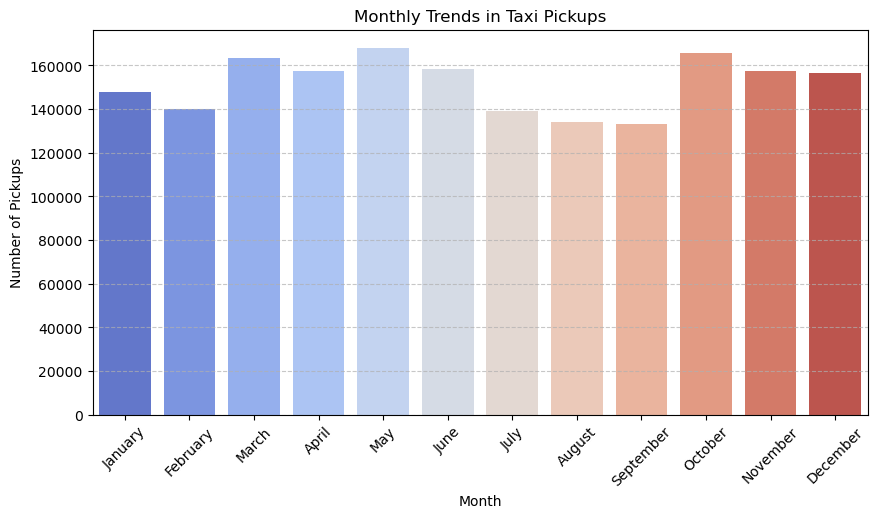

In [53]:
# Show the monthly trends in pickups

# Extract month from datetime (1 = January, 12 = December)
dfLatestData["month"] = dfLatestData["tpep_pickup_datetime"].dt.month

# Group by month and count pickups
monthly_pickups = dfLatestData.groupby("month")["tpep_pickup_datetime"].count().reset_index()

# Map month numbers to names
month_mapping = {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
                 7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"}
monthly_pickups["month"] = monthly_pickups["month"].map(month_mapping)

plt.figure(figsize=(10,5))
sns.barplot(x="month", y="tpep_pickup_datetime", data=monthly_pickups, palette="coolwarm", order=month_mapping.values())

# Formatting
plt.title("Monthly Trends in Taxi Pickups")
plt.xlabel("Month")
plt.ylabel("Number of Pickups")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()



##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [54]:
# Analyse the above parameters
print("Fare amount - ")
print(dfLatestData.fare_amount.describe())
print("***********************************")
print("Tip amount - ")
print(dfLatestData.tip_amount.describe())
print("***********************************")
print("Total amount - ")
print(dfLatestData.total_amount.describe())
print("***********************************")
print("Trip distance  - ")
print(dfLatestData.trip_distance.describe())
print("***********************************")

Fare amount - 
count    1.821033e+06
mean     1.974853e+01
std      1.076528e+02
min      0.000000e+00
25%      9.300000e+00
50%      1.350000e+01
75%      2.190000e+01
max      1.431635e+05
Name: fare_amount, dtype: float64
***********************************
Tip amount - 
count    1.821033e+06
mean     3.594088e+00
std      4.074058e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.860000e+00
75%      4.470000e+00
max      2.230800e+02
Name: tip_amount, dtype: float64
***********************************
Total amount - 
count    1.821033e+06
mean     2.890718e+01
std      1.085346e+02
min      0.000000e+00
25%      1.596000e+01
50%      2.100000e+01
75%      3.060000e+01
max      1.431675e+05
Name: total_amount, dtype: float64
***********************************
Trip distance  - 
count    1.821033e+06
mean     3.496804e+00
std      2.594803e+01
min      0.000000e+00
25%      1.050000e+00
50%      1.780000e+00
75%      3.340000e+00
max      1.096143e+04
Name: trip_distance, dt

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [55]:
# Create a df with non zero entries for the selected parameters.

dfLatestDataNZ = dfLatestData[~(dfLatestData.trip_distance == 0) ]
dfLatestDataNZ = dfLatestDataNZ[~(dfLatestData.total_amount == 0) ]
dfLatestDataNZ = dfLatestDataNZ[~(dfLatestData.fare_amount == 0) ]
dfLatestDataNZ

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
2               2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
4               2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
5               2  2023-12-01 00:57:08   2023-12-01 01:05:49              1.0   
6               2  2023-12-01 00:46:28   2023-12-01 00:59:29              2.0   
...           ...                  ...                   ...              ...   
1896394         2  2023-06-30 23:19:44   2023-06-30 23:32:53              1.0   
1896395         2  2023-06-30 23:53:10   2023-07-01 00:05:55              1.0   
1896397         1  2023-06-30 23:50:42   2023-07-01 00:20:00              2.0   
1896398         1  2023-06-30 23:05:31   2023-06-30 23:15:52              1.0   
1896399         2  2023-07-01 00:00:51   2023-07-01 00:24:19              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
0                 3.99         1.0                  2           148   
2                 1.05         1.0                  2           161   
4                 0.40         1.0                  2            68   
5                 1.66         1.0                  2           114   
6                 2.45         1.0                  2           164   
...                ...         ...                ...           ...   
1896394           2.03         1.0                  2            79   
1896395           2.63         1.0                  2           170   
1896397           5.40         1.0                  2            87   
1896398           1.00         1.0                  2            87   
1896399           5.04         1.0                  2           209   

         DOLocationID  payment_type  ...  tip_amount  tolls_amount  \
0                  50             1  ...        5.66           0.0   
2                 161             1  ...        3.14           0.0   
4                  68             1  ...        0.00           0.0   
5                 186             1  ...        3.14           0.0   
6                 232             1  ...        1.00           0.0   
...               ...           ...  ...         ...           ...   
1896394           170             1  ...        3.84           0.0   
1896395           143             1  ...        4.80           0.0   
1896397           161             1  ...        2.00           0.0   
1896398           231             2  ...        0.00           0.0   
1896399           225             1  ...        4.56           0.0   

         improvement_surcharge  total_amount  congestion_surcharge  \
0                          1.0         33.96                   2.5   
2                          1.0         18.84                   2.5   
4                          1.0         10.10                   2.5   
5                          1.0         18.84                   2.5   
6                          1.0         20.90                   2.5   
...                        ...           ...                   ...   
1896394                    1.0         23.04                   2.5   
1896395                    1.0         24.00                   2.5   
1896397                    1.0         39.40                   2.5   
1896398                    1.0         15.70                   2.5   
1896399                    1.0         34.96                   2.5   

         airport_fee  trip_duration  hour  month  day_of_week  
0                0.0          22.35     0     12            4  
2                0.0          10.63     0     12            4  
4                0.0           3.17     0     12            4  
5                0.0           8.68     0     12            4  
6                0.0          13.02     0     12            4  
...              ...            ...   ...    ...          ...  
1896394          0.0          13.15    23      6     

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

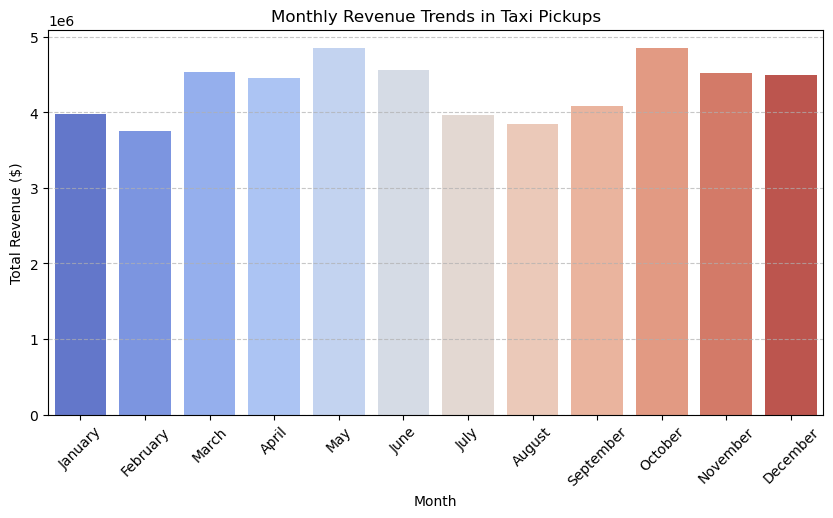

In [56]:
# Group data by month and analyse monthly revenue

# Group by month and sum the total amount
monthly_revenue = dfLatestDataNZ.groupby("month")["total_amount"].sum().reset_index()

# Map month numbers to names
month_mapping = {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
                 7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"}
monthly_revenue["month"] = monthly_revenue["month"].map(month_mapping)

plt.figure(figsize=(10,5))
sns.barplot(x="month", y="total_amount", data=monthly_revenue, palette="coolwarm", order=month_mapping.values())

# Formatting
plt.title("Monthly Revenue Trends in Taxi Pickups")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [57]:
# Calculate proportion of each quarter

dfLatestDataNZ["quarter"] = dfLatestDataNZ["tpep_pickup_datetime"].dt.quarter

# Group by quarter and sum the total amount
quarterly_revenue = dfLatestDataNZ.groupby("quarter")["total_amount"].sum().reset_index()

# Calculate the proportion of each quarter
total_revenue = quarterly_revenue["total_amount"].sum()
quarterly_revenue["proportion"] = (quarterly_revenue["total_amount"] / total_revenue) * 100

# Rename quarters for better visualization
quarter_mapping = {1: "Q1 (Jan-Mar)", 2: "Q2 (Apr-Jun)", 3: "Q3 (Jul-Sep)", 4: "Q4 (Oct-Dec)"}
quarterly_revenue["quarter"] = quarterly_revenue["quarter"].map(quarter_mapping)

# Display the proportion data
print(quarterly_revenue)


        quarter  total_amount  proportion
0  Q1 (Jan-Mar)   12260463.78   23.636989
1  Q2 (Apr-Jun)   13855001.99   26.711105
2  Q3 (Jul-Sep)   11893105.09   22.928757
3  Q4 (Oct-Dec)   13861248.77   26.723148


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

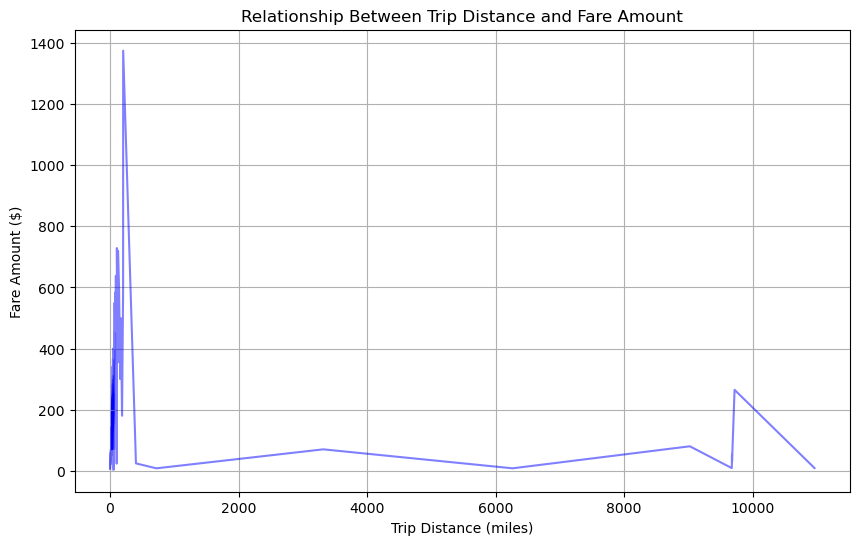

In [58]:
# Show how trip fare is affected by distance

# Remove negative or zero values for trip_distance and fare_amount (invalid data)
dfLatestDataNZ = dfLatestDataNZ[(dfLatestDataNZ["trip_distance"] > 0) & (dfLatestDataNZ["fare_amount"] > 0)]
plt.figure(figsize=(10,6))
sns.lineplot(x="trip_distance", y="fare_amount", data=dfLatestDataNZ, alpha=0.5, color="blue")

# Formatting
plt.title("Relationship Between Trip Distance and Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.grid(True)

# Show plot
plt.show()




**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

Correlation between Fare Amount and Trip Duration: 0.0452


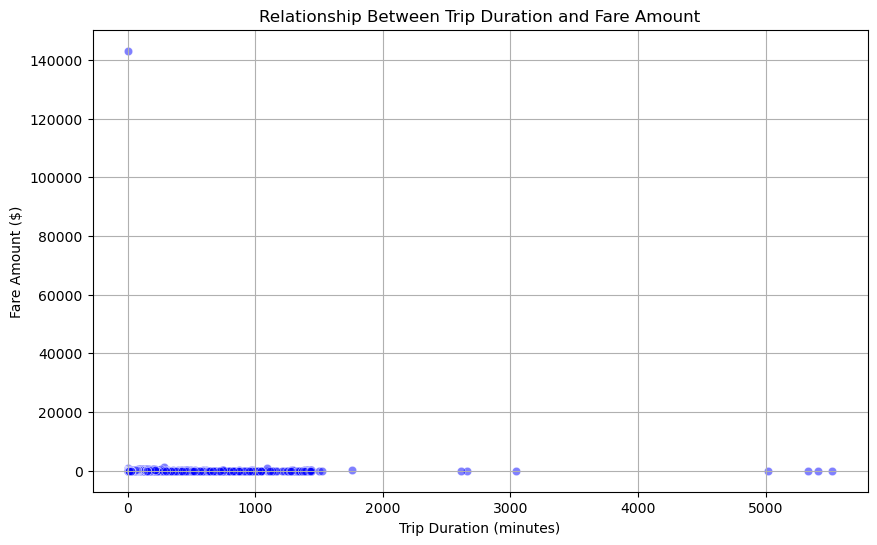

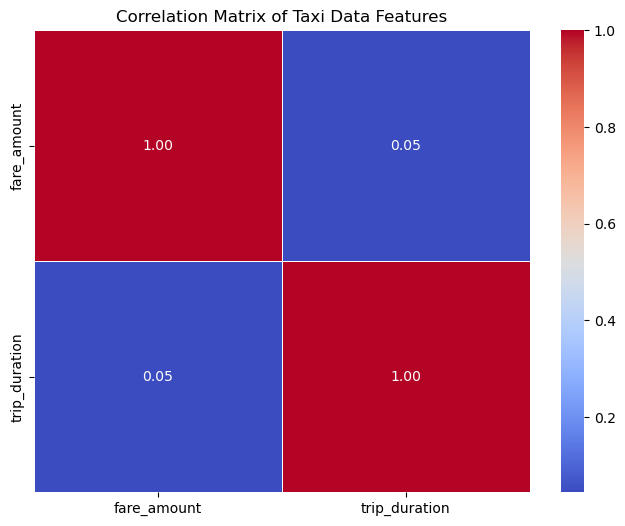

In [59]:
# Show relationship between fare and trip duration

# Remove invalid or zero values for trip_duration and fare_amount
dfLatestDataNZ = dfLatestDataNZ[(dfLatestDataNZ["trip_duration"] > 0) & (dfLatestDataNZ["fare_amount"] > 0)]
correlation = dfLatestDataNZ["fare_amount"].corr(dfLatestDataNZ["trip_duration"])
print(f"Correlation between Fare Amount and Trip Duration: {correlation:.4f}")

plt.figure(figsize=(10,6))
sns.scatterplot(x="trip_duration", y="fare_amount", data=dfLatestDataNZ, alpha=0.5, color="blue")

# Formatting
plt.title("Relationship Between Trip Duration and Fare Amount")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Fare Amount ($)")
plt.grid(True)

# Show plot
plt.show()

# Select relevant columns
corr_matrix = dfLatestDataNZ[["fare_amount", "trip_duration"]].corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Formatting
plt.title("Correlation Matrix of Taxi Data Features")

# Show plot
plt.show()




Correlation between Fare Amount and Passenger Count: 0.0073


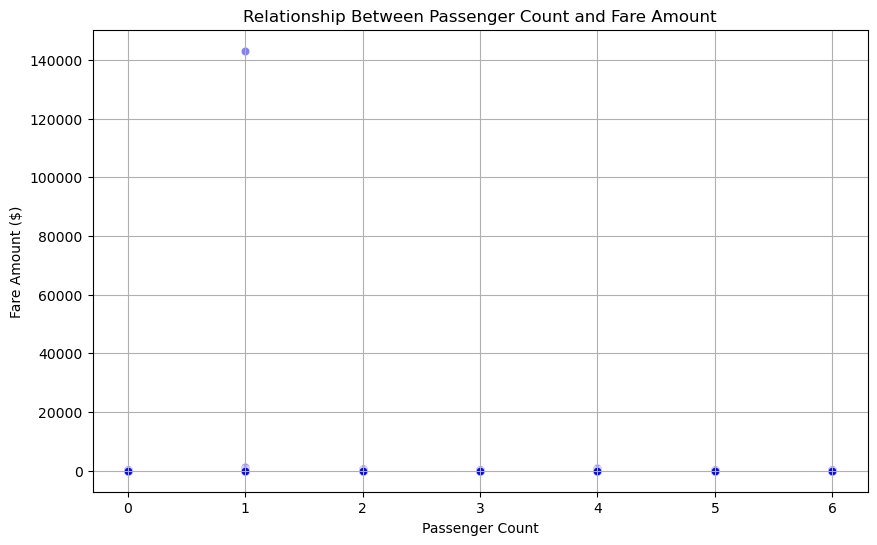

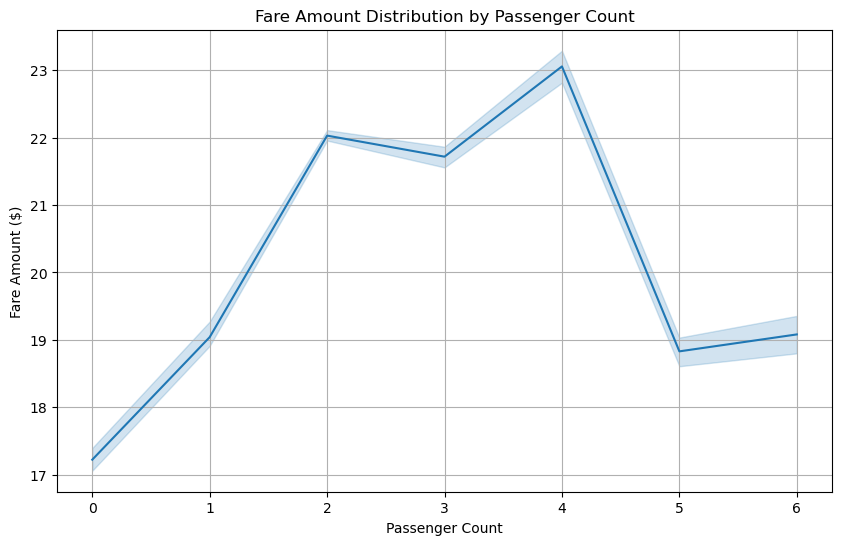

In [60]:
# Show relationship between fare and number of passengers

# Compute correlation
correlation = dfLatestDataNZ["fare_amount"].corr(dfLatestDataNZ["passenger_count"])
print(f"Correlation between Fare Amount and Passenger Count: {correlation:.4f}")

plt.figure(figsize=(10,6))
sns.scatterplot(x="passenger_count", y="fare_amount", data=dfLatestDataNZ, alpha=0.5, color="blue")

# Formatting
plt.title("Relationship Between Passenger Count and Fare Amount")
plt.xlabel("Passenger Count")
plt.ylabel("Fare Amount ($)")
plt.grid(True)

# Show plot
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(x="passenger_count", y="fare_amount", data=dfLatestDataNZ, palette="coolwarm")

# Formatting
plt.title("Fare Amount Distribution by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Fare Amount ($)")
plt.grid(True)

# Show plot
plt.show()



Correlation between Tip Amount and Trip Distance: 0.1041


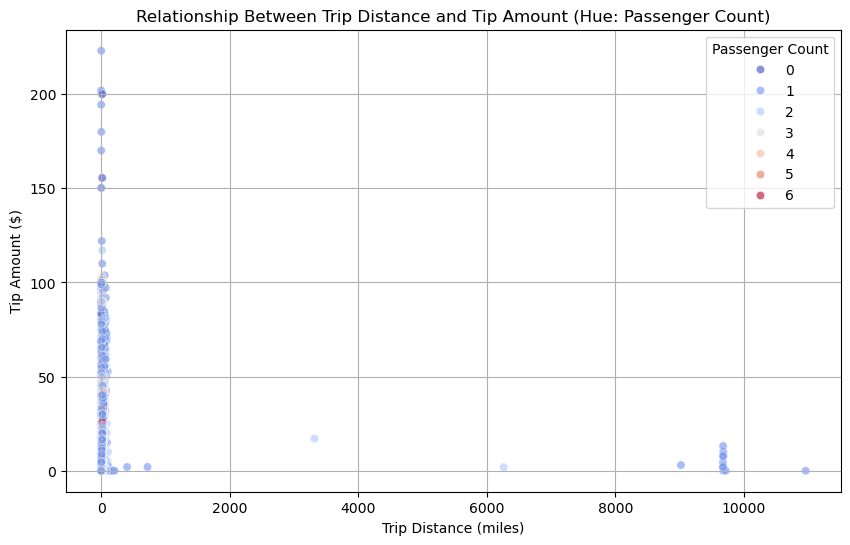

In [61]:
# Show relationship between tip and trip distance

# Compute correlation
correlation = dfLatestDataNZ["tip_amount"].corr(dfLatestDataNZ["trip_distance"])
print(f"Correlation between Tip Amount and Trip Distance: {correlation:.4f}")

plt.figure(figsize=(10,6))
sns.scatterplot(x="trip_distance", y="tip_amount", hue="passenger_count", data=dfLatestDataNZ, alpha=0.6, palette="coolwarm")

# Formatting
plt.title("Relationship Between Trip Distance and Tip Amount (Hue: Passenger Count)")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Tip Amount ($)")
plt.legend(title="Passenger Count")
plt.grid(True)

# Show plot
plt.show()


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

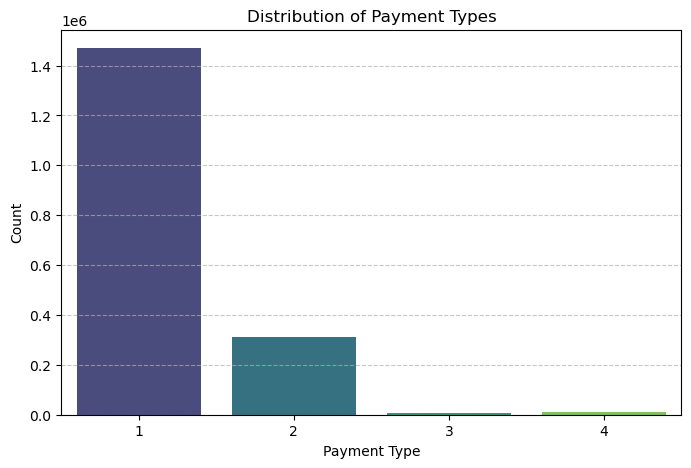

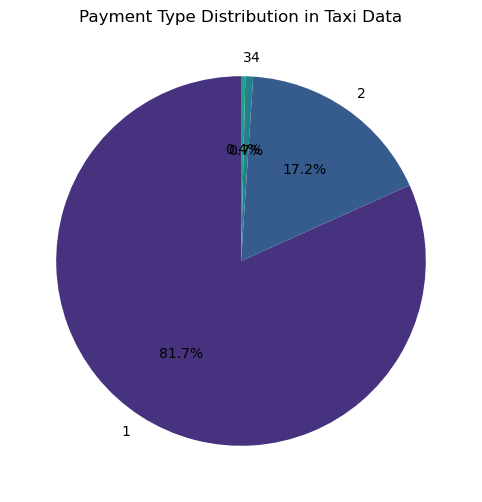

In [62]:
# Analyse the distribution of different payment types (payment_type).

dfLatestDataNZ = dfLatestDataNZ[dfLatestDataNZ["payment_type"].notna()]

plt.figure(figsize=(8,5))
sns.countplot(x="payment_type", data=dfLatestDataNZ, palette="viridis")

# Formatting
plt.title("Distribution of Payment Types")
plt.xlabel("Payment Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

plt.figure(figsize=(8,6))

# Count unique payment types
payment_counts = dfLatestDataNZ["payment_type"].value_counts()
labels = payment_counts.index

# Pie chart
plt.pie(payment_counts, labels=labels, autopct="%1.1f%%", colors=sns.color_palette("viridis"), startangle=90)

# Formatting
plt.title("Payment Type Distribution in Taxi Data")
plt.show()


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [63]:
# !pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [64]:
import geopandas as gpd
os.getcwd()
# os.chdir('/Users/deepa.thangavelu/taxi_zones')
os.chdir('/content/Assignments/EDA/data_NYC_Taxi/taxi_zones')
os.getcwd()
# Read the shapefile using geopandas
zones = gpd.read_file("taxi_zones.shp")
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

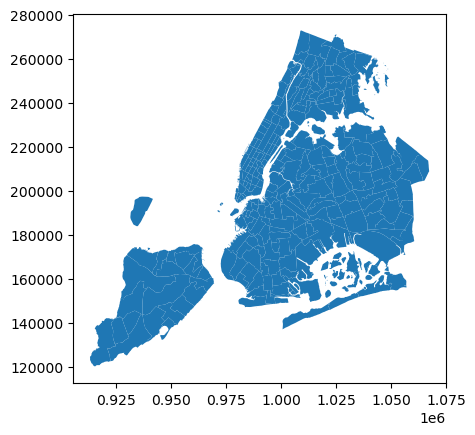

In [65]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [66]:
# Merge zones and trip records using locationID and PULocationID

# Perform the merge (on a common key like 'region_id')
merged_gdf = dfLatestDataNZ.merge(zones, left_on="PULocationID", right_on="LocationID", how="left")  # Use 'right' or 'inner' if needed

# Check the merged result
merged_gdf.head()


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
1         2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
2         2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
3         2  2023-12-01 00:57:08   2023-12-01 01:05:49              1.0   
4         2  2023-12-01 00:46:28   2023-12-01 00:59:29              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.99         1.0                  2           148            50   
1           1.05         1.0                  2           161           161   
2           0.40         1.0                  2            68            68   
3           1.66         1.0                  2           114           186   
4           2.45         1.0                  2           164           232   

   payment_type  ...  month  day_of_week  quarter  OBJECTID  Shape_Leng  \
0             1  ...     12            4        4     148.0    0.039131   
1             1  ...     12            4        4     161.0    0.035804   
2             1  ...     12            4        4      68.0    0.049337   
3             1  ...     12            4        4     114.0    0.031727   
4             1  ...     12            4        4     164.0    0.035772   

   Shape_Area                     zone  LocationID    borough  \
0    0.000070          Lower East Side       148.0  Manhattan   
1    0.000072           Midtown Center       161.0  Manhattan   
2    0.000111             East Chelsea        68.0  Manhattan   
3    0.000047  Greenwich Village South       114.0  Manhattan   
4    0.000056            Midtown South       164.0  Manhattan   

                                            geometry  
0  POLYGON ((988552.836 201677.665, 988387.669 20...  
1  POLYGON ((991081.026 214453.698, 990952.644 21...  
2  POLYGON ((983690.405 209040.369, 983550.612 20...  
3  POLYGON ((986306.712 203122.786, 986300.242 20...  
4  POLYGON ((988787.425 210315.593, 988662.868 21...  

[5 rows x 31 columns]

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

(251, 2)
     Location_ID  Trip_Count
121          132       94944
223          237       86450
150          161       85370
222          236       77087
151          162       65189
..           ...         ...
240          255         465
92            97         454
7             10         444
62            66         440
169          181         383

[75 rows x 2 columns]


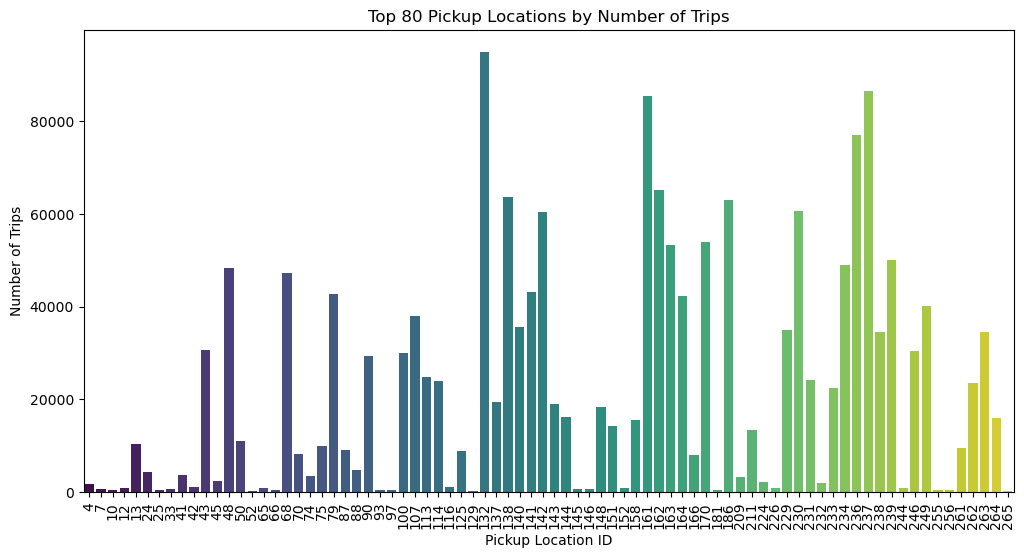

In [67]:
# Group data by location and calculate the number of trips

# Group by pickup location and count trips
trip_counts = merged_gdf.groupby("PULocationID")["tpep_pickup_datetime"].count().reset_index()

# Rename columns for better readability
trip_counts.columns = ["Location_ID", "Trip_Count"]

# Sort locations by trip count in descending order
trip_counts = trip_counts.sort_values(by="Trip_Count", ascending=False)

print(trip_counts.shape)
# Display the top 10 locations with the most trips
print(trip_counts.head(75))

# Plot the top 10 locations
plt.figure(figsize=(12, 6))
sns.barplot(data=trip_counts.head(80), x="Location_ID", y="Trip_Count", palette="viridis")
plt.xlabel("Pickup Location ID")
plt.ylabel("Number of Trips")
plt.title("Top 80 Pickup Locations by Number of Trips")
plt.xticks(rotation=90)
plt.show()

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

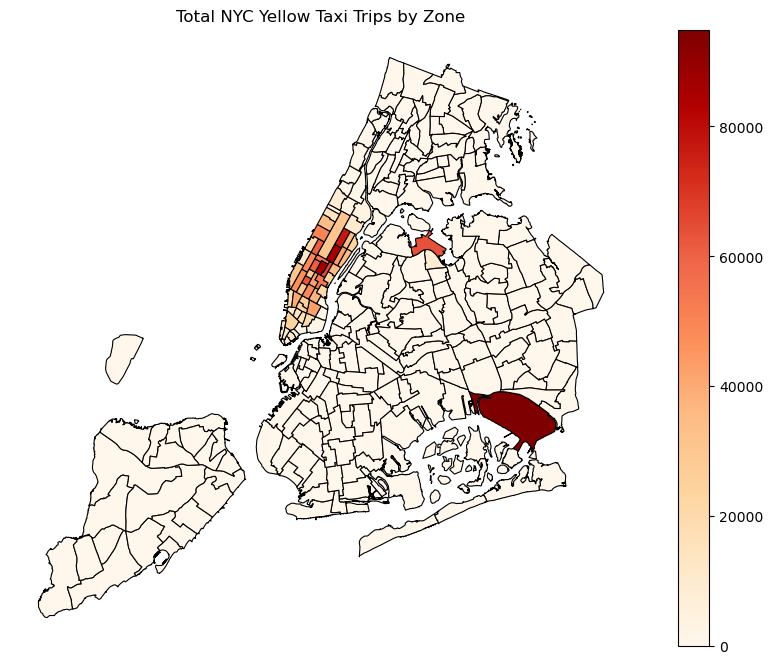

In [68]:
# Merge trip counts back to the zones GeoDataFrame
import geopandas as gpd

gdf = gpd.read_file("taxi_zones.shp")
# Group by Pickup Location and Count Trips
trip_counts = merged_gdf.groupby("PULocationID")["tpep_pickup_datetime"].count().reset_index()
trip_counts.columns = ["LocationID", "Trip_Count"]

# Merge with GeoDataFrame on Location ID
merged_gdf = gdf.merge(trip_counts, left_on="LocationID", right_on="LocationID", how="left")

# Fill NaN values (zones with no trips) with 0
merged_gdf["Trip_Count"] = merged_gdf["Trip_Count"].fillna(0)

# Plot the map
fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf.plot(column="Trip_Count", cmap="OrRd", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

# Formatting
plt.title("Total NYC Yellow Taxi Trips by Zone")
plt.axis("off")

# Show Plot
plt.show()




The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

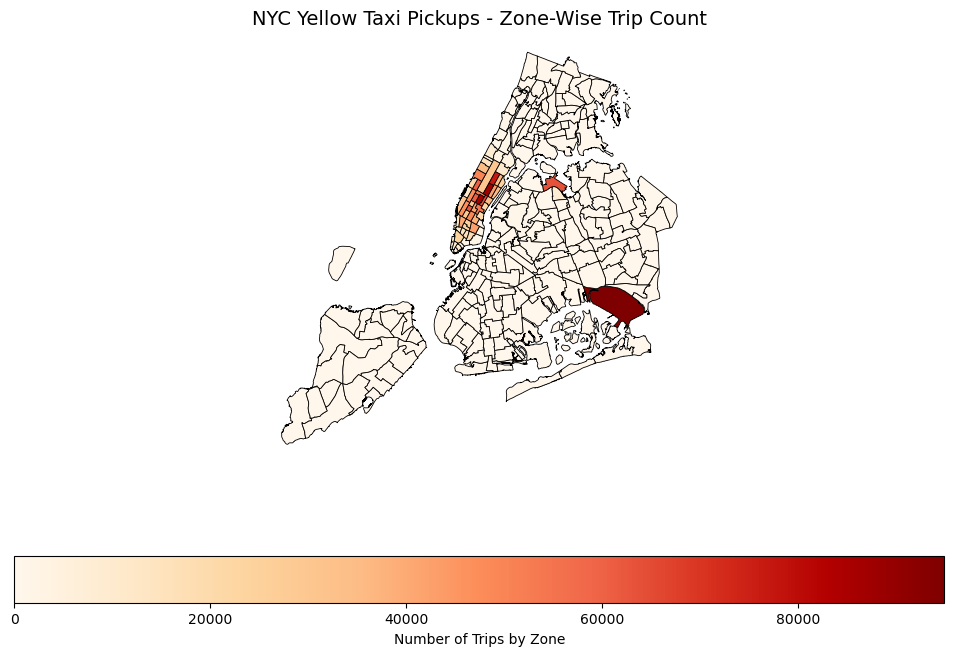

In [69]:
# Define figure and axis


# Plot the map and display it


# Group by Pickup Location (PULocationID) and Count Trips
# trip_counts = df.groupby("PULocationID")["tpep_pickup_datetime"].count().reset_index()
#ctrip_counts.columns = ["LocationID", "Trip_Count"]

# Merge the trip data with the GeoDataFrame
# merged_gdf = gdf.merge(trip_counts, left_on="LocationID", right_on="LocationID", how="left")

# Fill NaN values (zones with no trips) with 0
merged_gdf["Trip_Count"] = merged_gdf["Trip_Count"].fillna(0)

# Define Figure and Axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the color-coded map
merged_gdf.plot(column="Trip_Count", cmap="OrRd", linewidth=0.6, edgecolor="black",
                legend=True, legend_kwds={"label": "Number of Trips by Zone", "orientation": "horizontal"}, ax=ax)

# Formatting
ax.set_title("NYC Yellow Taxi Pickups - Zone-Wise Trip Count", fontsize=14)
ax.axis("off")  # Hide axes

# Display the Map
plt.show()




In [70]:
# can you try displaying the zones DF sorted by the number of trips?

# Sort the GeoDataFrame by Trip_Count in descending order
sorted_gdf = merged_gdf.sort_values(by="Trip_Count", ascending=False)

# Display the top 10 zones with the highest number of trips
print(sorted_gdf[["LocationID", "zone", "borough", "Trip_Count"]].head(10))


     LocationID                          zone    borough  Trip_Count
131         132                   JFK Airport     Queens     94944.0
236         237         Upper East Side South  Manhattan     86450.0
160         161                Midtown Center  Manhattan     85370.0
235         236         Upper East Side North  Manhattan     77087.0
161         162                  Midtown East  Manhattan     65189.0
137         138             LaGuardia Airport     Queens     63687.0
185         186  Penn Station/Madison Sq West  Manhattan     62979.0
229         230     Times Sq/Theatre District  Manhattan     60704.0
141         142           Lincoln Square East  Manhattan     60471.0
169         170                   Murray Hill  Manhattan     53973.0


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [71]:
# Find routes which have the slowest speeds at different times of the day
# Merge with GeoDataFrame on Location ID
import geopandas as gpd

gdf = gpd.read_file("taxi_zones.shp")
# Perform the merge (on a common key like 'region_id')
merged_gdf_insights = dfLatestDataNZ.merge(zones, left_on="PULocationID", right_on="LocationID", how="left")  # Use 'right' or 'inner' if needed

# Check the merged result
merged_gdf_insights.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-12-01 00:27:51   2023-12-01 00:50:12              1.0   
1         2  2023-12-01 00:06:19   2023-12-01 00:16:57              1.0   
2         2  2023-12-01 00:16:07   2023-12-01 00:19:17              1.0   
3         2  2023-12-01 00:57:08   2023-12-01 01:05:49              1.0   
4         2  2023-12-01 00:46:28   2023-12-01 00:59:29              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.99         1.0                  2           148            50   
1           1.05         1.0                  2           161           161   
2           0.40         1.0                  2            68            68   
3           1.66         1.0                  2           114           186   
4           2.45         1.0                  2           164           232   

   payment_type  ...  month  day_of_week  quarter  OBJECTID  Shape_Leng  \
0             1  ...     12            4        4     148.0    0.039131   
1             1  ...     12            4        4     161.0    0.035804   
2             1  ...     12            4        4      68.0    0.049337   
3             1  ...     12            4        4     114.0    0.031727   
4             1  ...     12            4        4     164.0    0.035772   

   Shape_Area                     zone  LocationID    borough  \
0    0.000070          Lower East Side       148.0  Manhattan   
1    0.000072           Midtown Center       161.0  Manhattan   
2    0.000111             East Chelsea        68.0  Manhattan   
3    0.000047  Greenwich Village South       114.0  Manhattan   
4    0.000056            Midtown South       164.0  Manhattan   

                                            geometry  
0  POLYGON ((988552.836 201677.665, 988387.669 20...  
1  POLYGON ((991081.026 214453.698, 990952.644 21...  
2  POLYGON ((983690.405 209040.369, 983550.612 20...  
3  POLYGON ((986306.712 203122.786, 986300.242 20...  
4  POLYGON ((988787.425 210315.593, 988662.868 21...  

[5 rows x 31 columns]

In [72]:
merged_gdf_insights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798831 entries, 0 to 1798830
Data columns (total 31 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [73]:


# Group by pickup/dropoff locations and hour to get average trip duration and total distance
route_hourly_stats = (
    merged_gdf_insights
    .groupby(["PULocationID", "DOLocationID", "hour"])
    .agg(
        avg_trip_duration=("trip_duration", "mean"),
        total_distance=("trip_distance", "sum"),
        trip_count=("trip_distance", "count")
    )
    .reset_index()
)

# Calculate speed for each route per hour
route_hourly_stats["speed"] = route_hourly_stats["total_distance"] / route_hourly_stats["avg_trip_duration"]

# Find the slowest routes for each hour (min speed)
slowest_routes = (
    route_hourly_stats.loc[route_hourly_stats.groupby("hour")["speed"].idxmin()]
    .sort_values(by="hour")
)

# Display slowest routes for each hour
print(slowest_routes[["hour", "PULocationID", "DOLocationID", "speed", "trip_count"]])


        hour  PULocationID  DOLocationID     speed  trip_count
19789      0            74           116  0.006741           2
113152     1           258           258  0.000437           1
60074      2           144           100  0.002033           1
64709      3           151           151  0.003003           1
104127     4           237           238  0.002006           1
56999      5           142           142  0.000396           1
18345      6            70           138  0.001429           1
40343      7           128           128  0.001923           1
30099      8           100             7  0.000658           1
36176      9           113           244  0.001412           1
8488      10            45            45  0.000991           1
28669     11            90           209  0.002640           1
34893     12           113            66  0.002401           1
95632     13           232            65  0.000089           1
57177     14           142           159  0.004063     

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

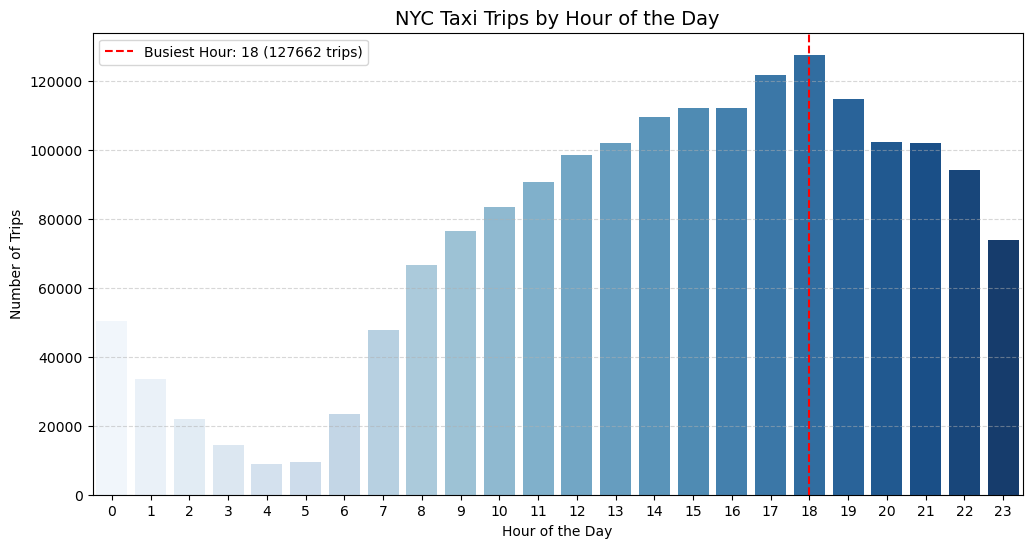

🟢 Busiest Hour: 18 with 127662 trips


In [74]:
# Visualise the number of trips per hour and find the busiest hour
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'hour' to count trips
hourly_trips = merged_gdf_insights.groupby("hour")["tpep_pickup_datetime"].count().reset_index()
hourly_trips.rename(columns={"tpep_pickup_datetime": "trip_count"}, inplace=True)

# Identify the busiest hour
busiest_hour = hourly_trips.loc[hourly_trips["trip_count"].idxmax()]

# Plot the hourly trip distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_trips, x="hour", y="trip_count", palette="Blues")

# Highlight busiest hour
plt.axvline(busiest_hour["hour"], color="red", linestyle="--", label=f"Busiest Hour: {busiest_hour['hour']} ({busiest_hour['trip_count']} trips)")

# Customize the plot
plt.title("NYC Taxi Trips by Hour of the Day", fontsize=14)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.xticks(range(24))  # Ensure all hours are labeled
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show the plot
plt.show()

# Print the busiest hour
print(f"🟢 Busiest Hour: {busiest_hour['hour']} with {busiest_hour['trip_count']} trips")



Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [75]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
import pandas as pd

# Group data by 'hour' and count the number of trips
hourly_trips = merged_gdf_insights.groupby("hour")["tpep_pickup_datetime"].count().reset_index()
hourly_trips.rename(columns={"tpep_pickup_datetime": "trip_count"}, inplace=True)

# Get the top 5 busiest hours
top_5_hours = hourly_trips.nlargest(5, "trip_count")

# Print the results
print("Top 5 Busiest Hours for NYC Taxi Trips")
print(top_5_hours.to_string(index=False))




Top 5 Busiest Hours for NYC Taxi Trips
 hour  trip_count
   18      127662
   17      121763
   19      114684
   15      112328
   16      112275


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

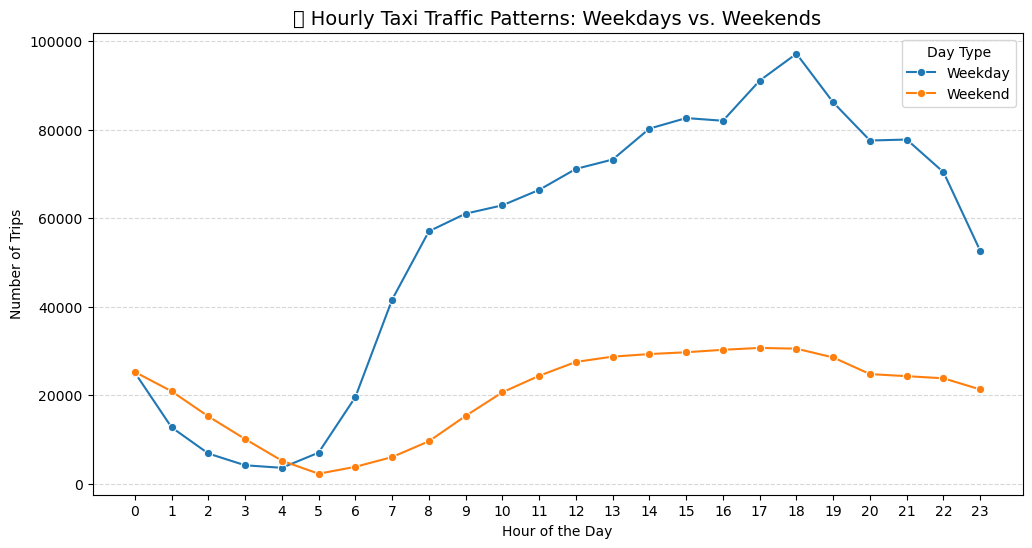

In [76]:
# Compare traffic trends for the week days and weekends

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'day_of_week' is present (0 = Monday, 6 = Sunday)
merged_gdf_insights["day_of_week"] = merged_gdf_insights["tpep_pickup_datetime"].dt.dayofweek  # Extract weekday

# Group by hour and day type (weekday/weekend)
merged_gdf_insights["day_type"] = merged_gdf_insights["day_of_week"].apply(lambda x: "Weekday" if x < 5 else "Weekend")

# Group by hour and day_type, count trips
hourly_trips = merged_gdf_insights.groupby(["hour", "day_type"])["tpep_pickup_datetime"].count().reset_index()
hourly_trips.rename(columns={"tpep_pickup_datetime": "trip_count"}, inplace=True)

# Plot the comparison
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_trips, x="hour", y="trip_count", hue="day_type", marker="o")

# Customize the plot
plt.title("🚖 Hourly Taxi Traffic Patterns: Weekdays vs. Weekends", fontsize=14)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.xticks(range(24))
plt.legend(title="Day Type")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show the plot
plt.show()


What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

<b> Rush Hour Differences: </b> </br>
Weekdays have sharp peaks at 8 AM & 6 PM (work commute). </br>
Weekends have more evenly distributed rides. </br>
<b> Late-Night Traffic: </b> </br>
Friday & Saturday nights have high taxi demand post-midnight. </br>
<b> Early Morning Lows: </b> </br>
4 AM - 6 AM has the least trips across all days. </br>


**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [77]:
# Find top 10 pickup and dropoff zones
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by pickup location and hour, count trips
top_pickup_zones = merged_gdf_insights.groupby("PULocationID")["tpep_pickup_datetime"].count().nlargest(10)
top_dropoff_zones = merged_gdf_insights.groupby("DOLocationID")["tpep_pickup_datetime"].count().nlargest(10)

print("🚖 Top 10 Pickup Zones:\n", top_pickup_zones)
print("\n📍 Top 10 Dropoff Zones:\n", top_dropoff_zones)



🚖 Top 10 Pickup Zones:
 PULocationID
132    94944
237    86450
161    85370
236    77087
162    65189
138    63687
186    62979
230    60704
142    60471
170    53973
Name: tpep_pickup_datetime, dtype: int64

📍 Top 10 Dropoff Zones:
 DOLocationID
236    80816
237    77117
161    71118
230    55831
170    53806
162    51823
142    51138
239    50960
141    48159
68     45878
Name: tpep_pickup_datetime, dtype: int64


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [78]:
# Find the top 10 and bottom 10 pickup/dropoff ratios


# Count pickups and drop-offs per zone
pickup_counts = merged_gdf_insights.groupby("PULocationID")["tpep_pickup_datetime"].count().rename("pickup_count")
dropoff_counts = merged_gdf_insights.groupby("DOLocationID")["tpep_pickup_datetime"].count().rename("dropoff_count")

# Merge pickup and drop-off counts
zone_trips = pd.DataFrame({"pickup_count": pickup_counts, "dropoff_count": dropoff_counts}).fillna(0)

# Calculate pickup/dropoff ratio
zone_trips["pickup_drop_ratio"] = zone_trips["pickup_count"] / (zone_trips["dropoff_count"] + 1)  # Avoid division by zero


In [79]:
# Sort by highest pickup/dropoff ratio
top_10_zones = zone_trips.sort_values("pickup_drop_ratio", ascending=False).head(10)

# Sort by lowest pickup/dropoff ratio
bottom_10_zones = zone_trips.sort_values("pickup_drop_ratio", ascending=True).head(10)

print("🚖 Top 10 Zones with Highest Pickup/Dropoff Ratio:\n", top_10_zones)
print("\n📉 Bottom 10 Zones with Lowest Pickup/Dropoff Ratio:\n", bottom_10_zones)


🚖 Top 10 Zones with Highest Pickup/Dropoff Ratio:
      pickup_count  dropoff_count  pickup_drop_ratio
70         8173.0          855.0           9.547897
132       94944.0        19323.0           4.913268
138       63687.0        21785.0           2.923299
199           2.0            0.0           2.000000
186       62979.0        39720.0           1.585534
43        30600.0        22218.0           1.377200
114       23963.0        17417.0           1.375761
249       40194.0        30260.0           1.328244
162       65189.0        51823.0           1.257892
161       85370.0        71118.0           1.200382

📉 Bottom 10 Zones with Lowest Pickup/Dropoff Ratio:
      pickup_count  dropoff_count  pickup_drop_ratio
99            0.0            2.0                0.0
3             0.0          107.0                0.0
109           0.0           25.0                0.0
5             0.0            9.0                0.0
30            0.0           15.0                0.0
245        

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [80]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones


# Define night hours (23:00 to 05:00)
night_hours = list(range(23, 24)) + list(range(0, 6))

# Filter data for trips occurring during night hours
night_data = merged_gdf_insights[merged_gdf_insights["hour"].isin(night_hours)]



In [81]:
# Count pickups and drop-offs per zone during night hours
night_pickups = night_data.groupby("PULocationID")["tpep_pickup_datetime"].count().rename("pickup_count")
night_dropoffs = night_data.groupby("DOLocationID")["tpep_pickup_datetime"].count().rename("dropoff_count")

# Merge into a DataFrame
night_traffic = pd.DataFrame({"pickup_count": night_pickups, "dropoff_count": night_dropoffs}).fillna(0)

# Sort zones by highest pickups and drop-offs
top_night_pickup_zones = night_traffic.sort_values("pickup_count", ascending=False).head(10)
top_night_dropoff_zones = night_traffic.sort_values("dropoff_count", ascending=False).head(10)

print("🚖 Top 10 Zones with Highest Night Pickups:\n", top_night_pickup_zones)
print("\n📍 Top 10 Zones with Highest Night Drop-offs:\n", top_night_dropoff_zones)


🚖 Top 10 Zones with Highest Night Pickups:
      pickup_count  dropoff_count
79        15429.0           8222
132       14328.0           1594
249       12388.0           4882
48        10359.0           6791
148        9554.0           4317
114        8694.0           2509
230        8114.0           4556
186        6892.0           3689
164        6078.0           4109
68         5951.0           5749

📍 Top 10 Zones with Highest Night Drop-offs:
      pickup_count  dropoff_count
79        15429.0           8222
48        10359.0           6791
170        4084.0           6188
68         5951.0           5749
107        5569.0           5686
141        3380.0           5225
263        3432.0           4933
249       12388.0           4882
230        8114.0           4556
229        2842.0           4336


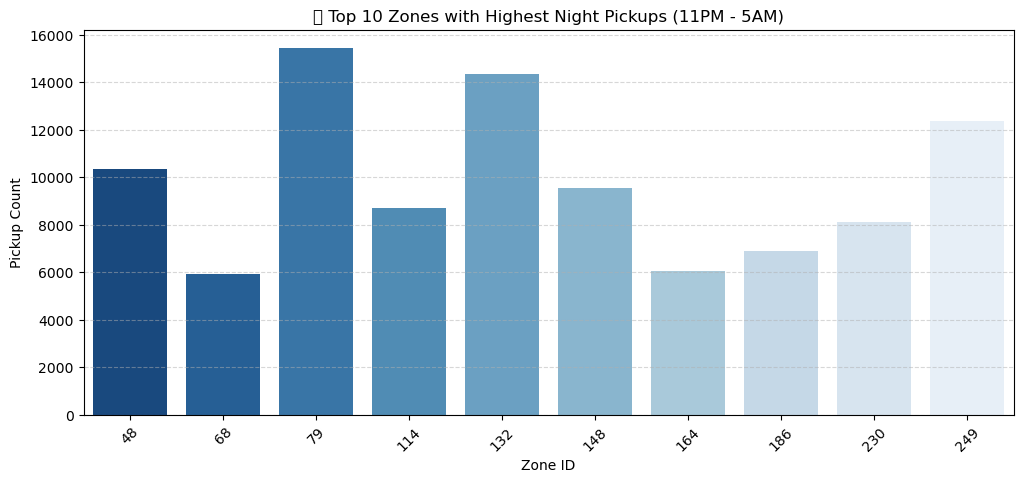

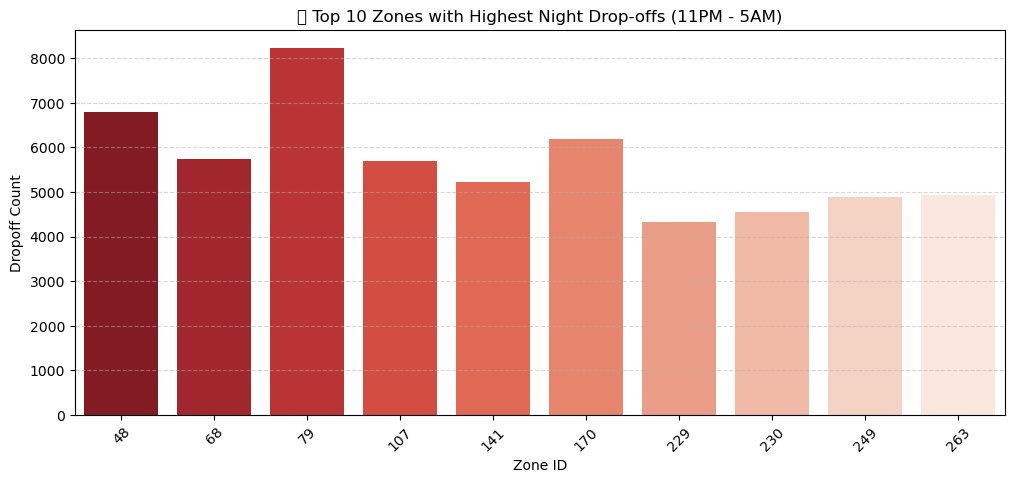

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot night pickup zones
plt.figure(figsize=(12, 5))
sns.barplot(x=top_night_pickup_zones.index, y=top_night_pickup_zones["pickup_count"], palette="Blues_r")
plt.xlabel("Zone ID")
plt.ylabel("Pickup Count")
plt.title("🚖 Top 10 Zones with Highest Night Pickups (11PM - 5AM)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Plot night dropoff zones
plt.figure(figsize=(12, 5))
sns.barplot(x=top_night_dropoff_zones.index, y=top_night_dropoff_zones["dropoff_count"], palette="Reds_r")
plt.xlabel("Zone ID")
plt.ylabel("Dropoff Count")
plt.title("📍 Top 10 Zones with Highest Night Drop-offs (11PM - 5AM)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [83]:
# Filter for night hours (11 PM to 5 AM)


# Define night and day hours
night_hours = list(range(23, 24)) + list(range(0, 6))  # 11 PM - 5 AM
day_hours = list(range(6, 23))  # 6 AM - 10 PM

# Filter trips for night and day
night_data = merged_gdf_insights[merged_gdf_insights["hour"].isin(night_hours)]
day_data = merged_gdf_insights[merged_gdf_insights["hour"].isin(day_hours)]


In [84]:
# Sum total revenue for night and day
night_revenue = night_data["total_amount"].sum()
day_revenue = day_data["total_amount"].sum()
total_revenue = night_revenue + day_revenue

# Calculate revenue share
night_share = (night_revenue / total_revenue) * 100
day_share = (day_revenue / total_revenue) * 100

print(f"🌙 Nighttime Revenue Share (11PM-5AM): {night_share:.2f}%")
print(f"☀️ Daytime Revenue Share (5AM-11PM): {day_share:.2f}%")


🌙 Nighttime Revenue Share (11PM-5AM): 11.99%
☀️ Daytime Revenue Share (5AM-11PM): 88.01%


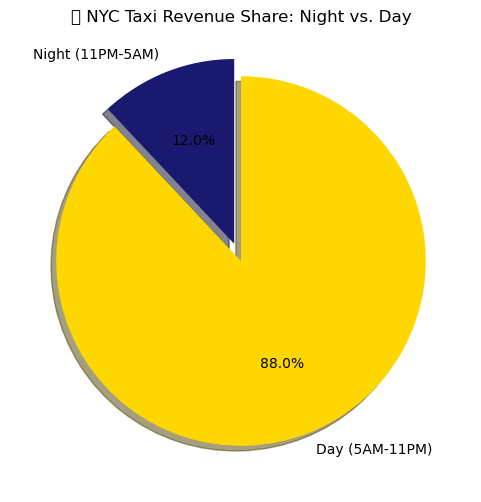

In [85]:
import matplotlib.pyplot as plt

# Plot revenue share
labels = ["Night (11PM-5AM)", "Day (5AM-11PM)"]
sizes = [night_share, day_share]
colors = ["midnightblue", "gold"]
explode = (0.1, 0)  # Slightly separate the night segment

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, explode=explode, shadow=True, startangle=90)
plt.title("🚖 NYC Taxi Revenue Share: Night vs. Day")
plt.show()


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [86]:
# Analyse the fare per mile per passenger for different passenger counts


# Avoid division errors (Remove trips with zero distance or zero passengers)
df_filtered = merged_gdf_insights[(merged_gdf_insights["trip_distance"] > 0) & (merged_gdf_insights["passenger_count"] > 0)]

# Calculate Fare per Mile
df_filtered["fare_per_mile"] = df_filtered["fare_amount"] / df_filtered["trip_distance"]

# Compute Fare per Mile per Passenger
df_filtered["fare_per_mile_per_passenger"] = df_filtered["fare_per_mile"] / df_filtered["passenger_count"]

# Group by Passenger Count & Compute Averages
fare_analysis = df_filtered.groupby("passenger_count")["fare_per_mile_per_passenger"].mean().reset_index()

# Rename columns for clarity
fare_analysis.columns = ["Passenger Count", "Avg Fare per Mile per Passenger"]

# Display the results
print(fare_analysis)



   Passenger Count  Avg Fare per Mile per Passenger
0              1.0                        11.058448
1              2.0                         6.430409
2              3.0                         3.908214
3              4.0                         4.442722
4              5.0                         1.709582
5              6.0                         1.350827


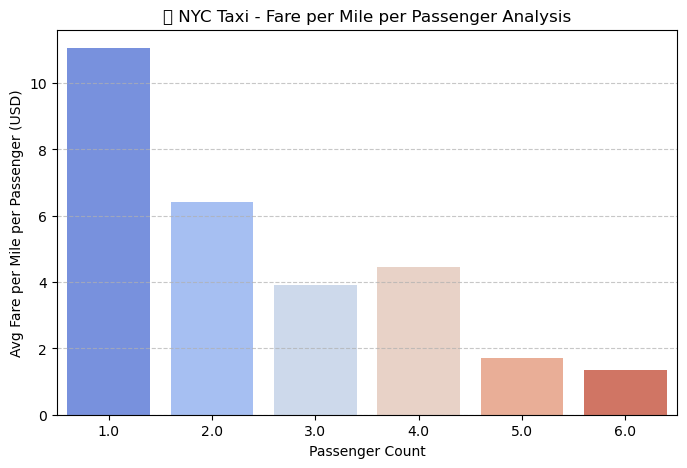

In [87]:

# Plot Avg Fare per Mile per Passenger for different passenger counts
plt.figure(figsize=(8,5))
sns.barplot(data=fare_analysis, x="Passenger Count", y="Avg Fare per Mile per Passenger", palette="coolwarm")

plt.xlabel("Passenger Count")
plt.ylabel("Avg Fare per Mile per Passenger (USD)")
plt.title("🚖 NYC Taxi - Fare per Mile per Passenger Analysis")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


✅ Insights from the Analysis </br>
Single-passenger trips may have the highest fare per mile per passenger.</br>
Multi-passenger trips reduce per-person costs, making ridesharing more cost-effective. </br>
If fare per mile does not decrease significantly with more passengers, taxis may not offer discounts for additional passengers. </br>
Compare with Uber/Lyft shared rides to analyze competitiveness. </br>

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [88]:
# Compare the average fare per mile for different days and for different times of the day


# Remove trips with zero distance or fare issues
df_filtered = merged_gdf_insights[(merged_gdf_insights["trip_distance"] > 0) & (merged_gdf_insights["fare_amount"] > 0)]

# Calculate fare per mile
df_filtered["fare_per_mile"] = df_filtered["fare_amount"] / df_filtered["trip_distance"]

# Group by hour of the day
hourly_fare = df_filtered.groupby("hour")["fare_per_mile"].mean().reset_index()

# Group by day of the week
daily_fare = df_filtered.groupby("day_of_week")["fare_per_mile"].mean().reset_index()

# Map days of the week for clarity
day_mapping = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
daily_fare["day_of_week"] = daily_fare["day_of_week"].map(day_mapping)

# Display results
print("🚕 Average Fare Per Mile by Hour:")
print(hourly_fare.head())

print("\n📆 Average Fare Per Mile by Day:")
print(daily_fare.head())



🚕 Average Fare Per Mile by Hour:
   hour  fare_per_mile
0     0      10.525229
1     1      11.267502
2     2       9.943004
3     3      10.884026
4     4      13.974439

📆 Average Fare Per Mile by Day:
  day_of_week  fare_per_mile
0      Monday      10.985666
1     Tuesday      12.163934
2   Wednesday      11.124297
3    Thursday      11.276304
4      Friday      10.911466


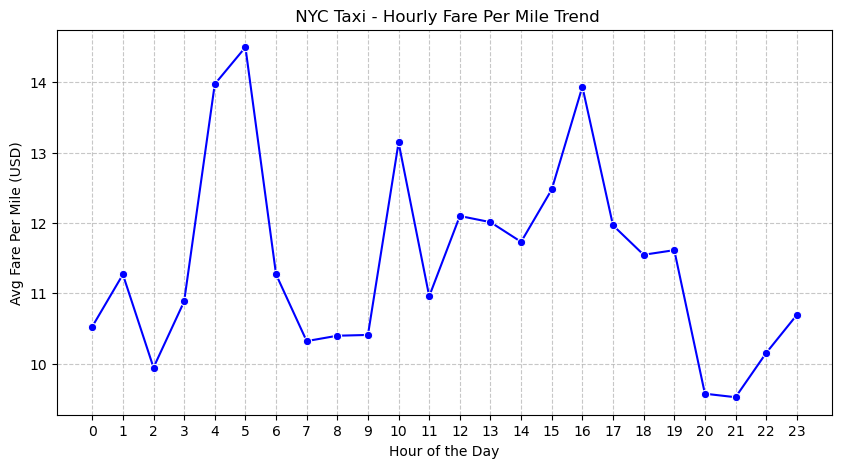

In [89]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_fare, x="hour", y="fare_per_mile", marker="o", color="b")

plt.xlabel("Hour of the Day")
plt.ylabel("Avg Fare Per Mile (USD)")
plt.title(" NYC Taxi - Hourly Fare Per Mile Trend")
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


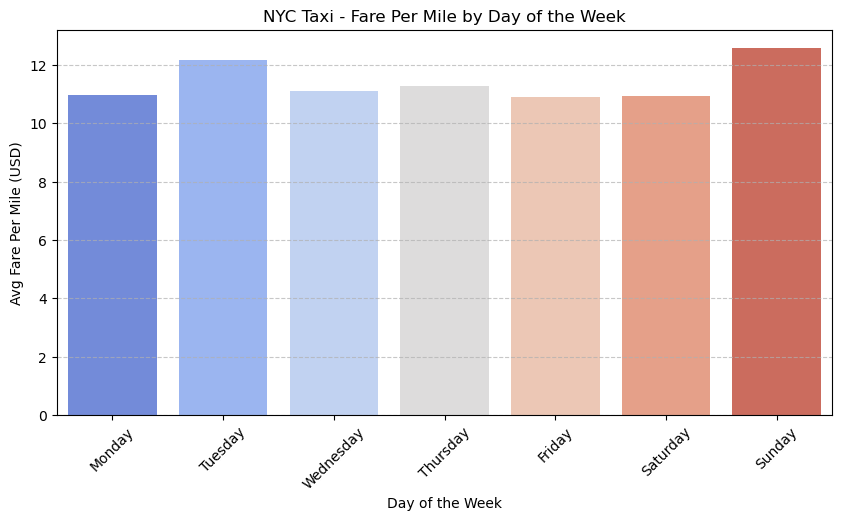

In [90]:
plt.figure(figsize=(10, 5))
sns.barplot(data=daily_fare, x="day_of_week", y="fare_per_mile", palette="coolwarm")

plt.xlabel("Day of the Week")
plt.ylabel("Avg Fare Per Mile (USD)")
plt.title("NYC Taxi - Fare Per Mile by Day of the Week")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


✅ 📊 Insights from the Analysis </br>
<b> Hourly Trends </b> </br>
</br>
Higher fare per mile during late-night hours (Midnight - 5 AM) due to demand & surcharge. </br>
Lower fares midday (12 PM - 5 PM) when competition is higher. </br>
</br>
<b> Daily Trends</br> </b>
</br>
Friday & Saturday may have the highest fare per mile due to night surge pricing.</br>
Weekdays have more stable fares, possibly due to commuter travel.</br>

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [91]:
# Compare fare per mile for different vendors

# Remove trips with zero distance or fare issues
df_filtered = merged_gdf_insights[(merged_gdf_insights["trip_distance"] > 0) & (merged_gdf_insights["fare_amount"] > 0)]

# Calculate fare per mile
df_filtered["fare_per_mile"] = df_filtered["fare_amount"] / df_filtered["trip_distance"]

# Group by Vendor and Hour to calculate average fare per mile
vendor_hourly_fare = df_filtered.groupby(["VendorID", "hour"])["fare_per_mile"].mean().reset_index()

# Display results
print("🚕 Average Fare Per Mile by Vendor & Hour:")
print(vendor_hourly_fare.head())


🚕 Average Fare Per Mile by Vendor & Hour:
   VendorID  hour  fare_per_mile
0         1     0       6.790272
1         1     1       7.029712
2         1     2       6.931255
3         1     3       6.534490
4         1     4       6.756154


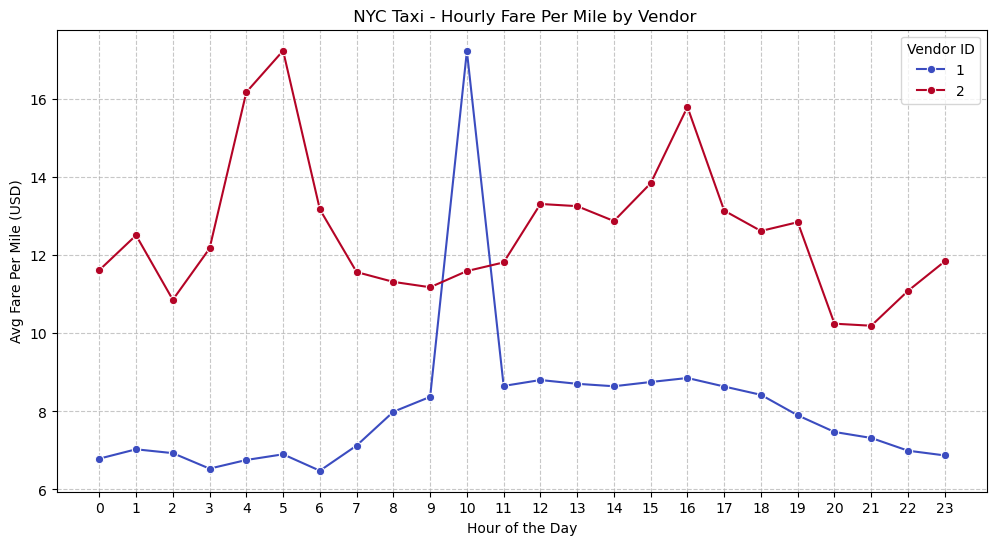

In [92]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=vendor_hourly_fare, x="hour", y="fare_per_mile", hue="VendorID", marker="o", palette="coolwarm")

plt.xlabel("Hour of the Day")
plt.ylabel("Avg Fare Per Mile (USD)")
plt.title(" NYC Taxi - Hourly Fare Per Mile by Vendor")
plt.xticks(range(0, 24))
plt.legend(title="Vendor ID")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


✅ 📊 Insights from the Analysis </br>
Hourly Trends for Vendors </br>
</br>
If one vendor consistently has higher fare per mile, it may indicate different pricing structures.</br>
Late-night surges could vary between vendors.</br>
Comparison of Vendors</br>
</br>
Identify if one vendor is cheaper or more expensive on average at certain hours.</br>

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [93]:
# Defining distance tiers

# We will analyze the average fare per mile for different vendors based on distance tiers:

# Short Trips (≤ 2 miles)
# Medium Trips (2 - 5 miles)
# Long Trips (> 5 miles)


# Remove trips with zero or negative distance/fare issues
df_filtered = merged_gdf_insights[(merged_gdf_insights["trip_distance"] > 0) & (merged_gdf_insights["fare_amount"] > 0)]

# Define Distance Tiers
def categorize_distance(dist):
    if dist <= 2:
        return "Short (≤2 miles)"
    elif 2 < dist <= 5:
        return "Medium (2-5 miles)"
    else:
        return "Long (>5 miles)"

# Apply categorization
df_filtered["distance_tier"] = df_filtered["trip_distance"].apply(categorize_distance)

# Calculate Fare Per Mile
df_filtered["fare_per_mile"] = df_filtered["fare_amount"] / df_filtered["trip_distance"]

# Group by Vendor & Distance Tier to calculate the average fare per mile
vendor_fare_tiers = df_filtered.groupby(["VendorID", "distance_tier"])["fare_per_mile"].mean().reset_index()

# Display results
print("🚕 Average Fare Per Mile by Vendor & Distance Tier:")
print(vendor_fare_tiers)




🚕 Average Fare Per Mile by Vendor & Distance Tier:
   VendorID       distance_tier  fare_per_mile
0         1     Long (>5 miles)       4.464973
1         1  Medium (2-5 miles)       6.365956
2         1    Short (≤2 miles)      10.534290
3         2     Long (>5 miles)       4.503356
4         2  Medium (2-5 miles)       6.549322
5         2    Short (≤2 miles)      17.931750


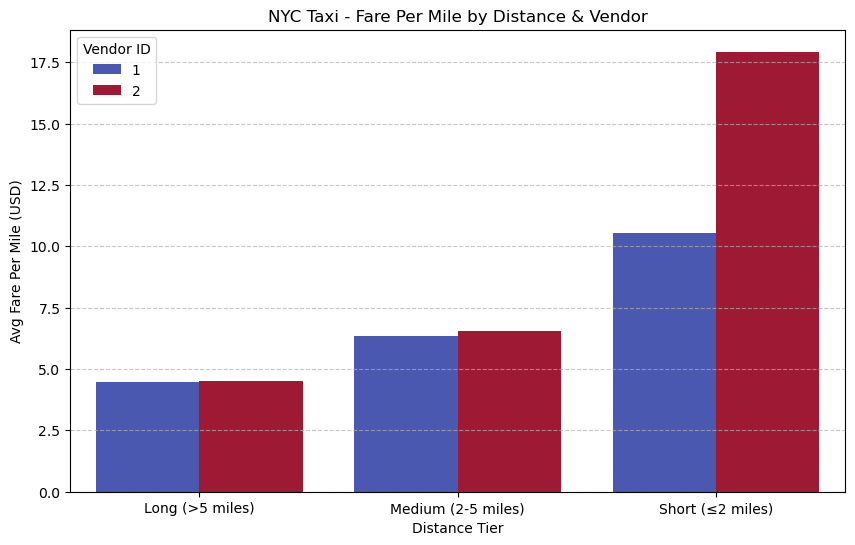

In [94]:
plt.figure(figsize=(10, 6))
sns.barplot(data=vendor_fare_tiers, x="distance_tier", y="fare_per_mile", hue="VendorID", palette="coolwarm")

plt.xlabel("Distance Tier")
plt.ylabel("Avg Fare Per Mile (USD)")
plt.title("NYC Taxi - Fare Per Mile by Distance & Vendor")
plt.legend(title="Vendor ID")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


✅ 📊 Insights from the Analysis </br>
Short Trips (≤2 miles) </br>
</br>
Do vendors charge a higher base fare per mile for short rides?</br>
Is there a significant difference in pricing between vendors?</br>
Medium Trips (2-5 miles)</br>
</br>
Is there a more stable fare per mile in this range?</br>
Long Trips (>5 miles)</br>
</br>
Are there vendors that offer better pricing for long rides?</br>

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [95]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

# Remove trips where tip_amount or total_amount is zero or negative
df_filtered = merged_gdf_insights[(merged_gdf_insights["total_amount"] > 0) & (merged_gdf_insights["tip_amount"] >= 0)]

# Compute Tip Percentage
df_filtered["tip_percentage"] = (df_filtered["tip_amount"] / df_filtered["total_amount"]) * 100

# Define Distance Categories
def categorize_distance(dist):
    if dist <= 2:
        return "Short (≤2 miles)"
    elif 2 < dist <= 5:
        return "Medium (2-5 miles)"
    else:
        return "Long (>5 miles)"

df_filtered["distance_tier"] = df_filtered["trip_distance"].apply(categorize_distance)

# Categorize Pickup Time (Morning, Afternoon, Night)
def categorize_time(hour):
    if 5 <= hour < 12:
        return "Morning (5AM-12PM)"
    elif 12 <= hour < 18:
        return "Afternoon (12PM-6PM)"
    else:
        return "Night (6PM-5AM)"

df_filtered["pickup_time_category"] = df_filtered["tpep_pickup_datetime"].dt.hour.apply(categorize_time)

# Display sample of processed data
print(df_filtered[["trip_distance", "passenger_count", "tip_percentage", "distance_tier", "pickup_time_category"]].head())



   trip_distance  passenger_count  tip_percentage       distance_tier  \
0           3.99              1.0       16.666667  Medium (2-5 miles)   
1           1.05              1.0       16.666667    Short (≤2 miles)   
2           0.40              1.0        0.000000    Short (≤2 miles)   
3           1.66              1.0       16.666667    Short (≤2 miles)   
4           2.45              2.0        4.784689  Medium (2-5 miles)   

  pickup_time_category  
0      Night (6PM-5AM)  
1      Night (6PM-5AM)  
2      Night (6PM-5AM)  
3      Night (6PM-5AM)  
4      Night (6PM-5AM)  


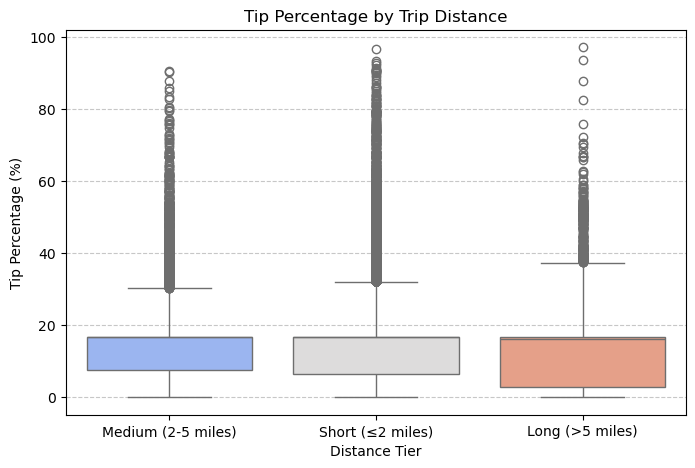

In [96]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_filtered, x="distance_tier", y="tip_percentage", palette="coolwarm")
plt.xlabel("Distance Tier")
plt.ylabel("Tip Percentage (%)")
plt.title("Tip Percentage by Trip Distance")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


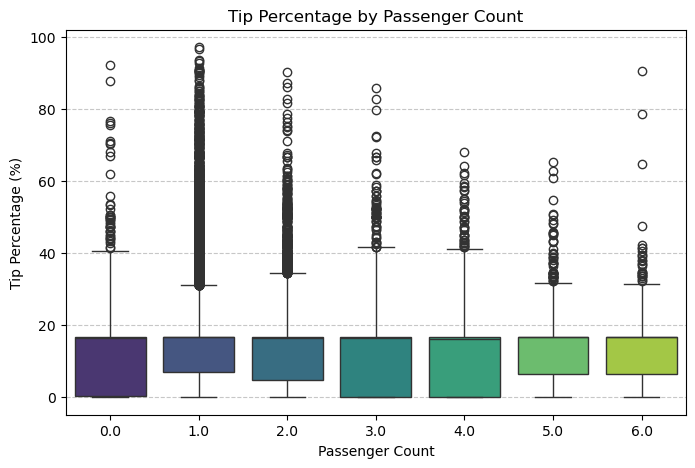

In [97]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_filtered, x="passenger_count", y="tip_percentage", palette="viridis")
plt.xlabel("Passenger Count")
plt.ylabel("Tip Percentage (%)")
plt.title("Tip Percentage by Passenger Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


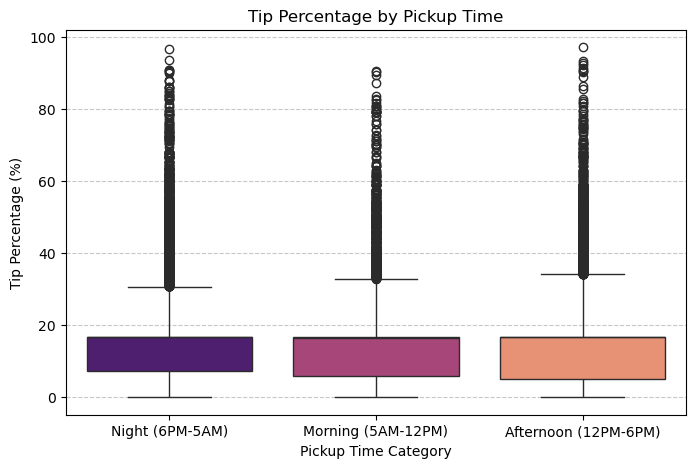

In [98]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_filtered, x="pickup_time_category", y="tip_percentage", palette="magma")
plt.xlabel("Pickup Time Category")
plt.ylabel("Tip Percentage (%)")
plt.title("Tip Percentage by Pickup Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


📊 Insights from the Analysis </br>
Tip % vs Distance </br>
</br>
Do longer trips have higher or lower tips? </br>
Is tipping behavior consistent across distances? </br>
Tip % vs Passenger Count </br>
</br>
Do single-passenger trips tip more than group rides? </br>
Are larger groups less likely to tip? </br>
Tip % vs Pickup Time </br>
</br>
Are morning rides tipped better than night rides? </br>
Are late-night riders tipping less? </br>

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [99]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

# We will compare two groups of trips based on tip percentage:

# Low Tip Trips: Tip < 10%
# High Tip Trips: Tip > 25%

# Define Tip Categories
def categorize_tip(percentage):
    if percentage < 10:
        return "Low Tip (<10%)"
    elif percentage > 25:
        return "High Tip (>25%)"
    else:
        return "Moderate Tip (10-25%)"

df_filtered["tip_category"] = df_filtered["tip_percentage"].apply(categorize_tip)

# Separate DataFrames
low_tip_df = df_filtered[df_filtered["tip_category"] == "Low Tip (<10%)"]
high_tip_df = df_filtered[df_filtered["tip_category"] == "High Tip (>25%)"]

# Display sample
print(df_filtered[["total_amount", "tip_percentage", "distance_tier", "pickup_time_category", "tip_category"]].head())




   total_amount  tip_percentage       distance_tier pickup_time_category  \
0         33.96       16.666667  Medium (2-5 miles)      Night (6PM-5AM)   
1         18.84       16.666667    Short (≤2 miles)      Night (6PM-5AM)   
2         10.10        0.000000    Short (≤2 miles)      Night (6PM-5AM)   
3         18.84       16.666667    Short (≤2 miles)      Night (6PM-5AM)   
4         20.90        4.784689  Medium (2-5 miles)      Night (6PM-5AM)   

            tip_category  
0  Moderate Tip (10-25%)  
1  Moderate Tip (10-25%)  
2         Low Tip (<10%)  
3  Moderate Tip (10-25%)  
4         Low Tip (<10%)  


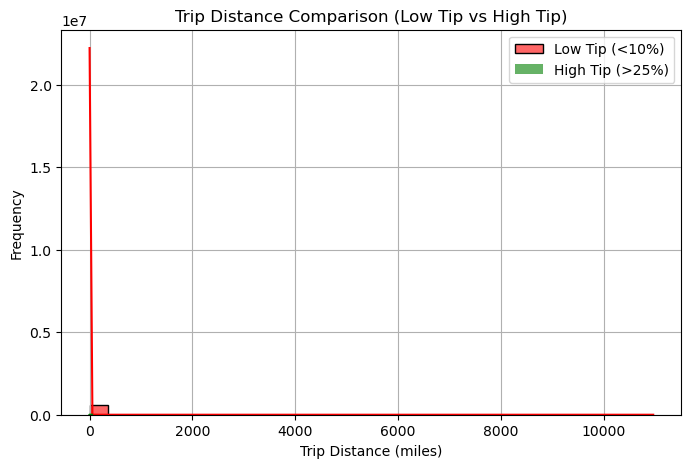

In [100]:
plt.figure(figsize=(8, 5))
sns.histplot(low_tip_df["trip_distance"], label="Low Tip (<10%)", color="red", kde=True, bins=30, alpha=0.6)
sns.histplot(high_tip_df["trip_distance"], label="High Tip (>25%)", color="green", kde=True, bins=30, alpha=0.6)
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency")
plt.title("Trip Distance Comparison (Low Tip vs High Tip)")
plt.legend()
plt.grid()
plt.show()


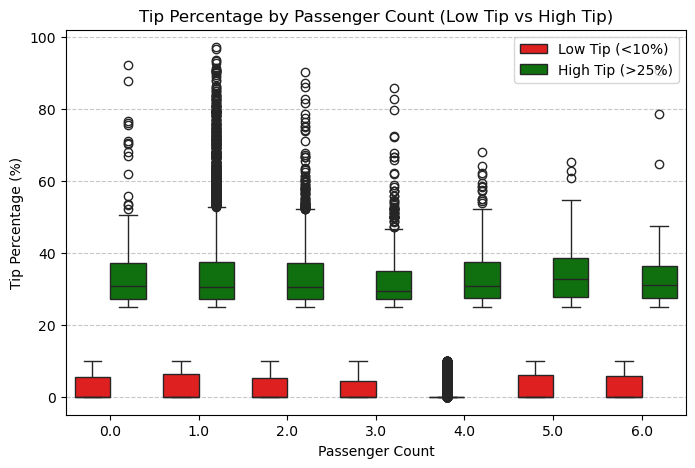

In [101]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_filtered[df_filtered["tip_category"].isin(["Low Tip (<10%)", "High Tip (>25%)"])], 
            x="passenger_count", y="tip_percentage", hue="tip_category", palette={"Low Tip (<10%)": "red", "High Tip (>25%)": "green"})
plt.xlabel("Passenger Count")
plt.ylabel("Tip Percentage (%)")
plt.title("Tip Percentage by Passenger Count (Low Tip vs High Tip)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()


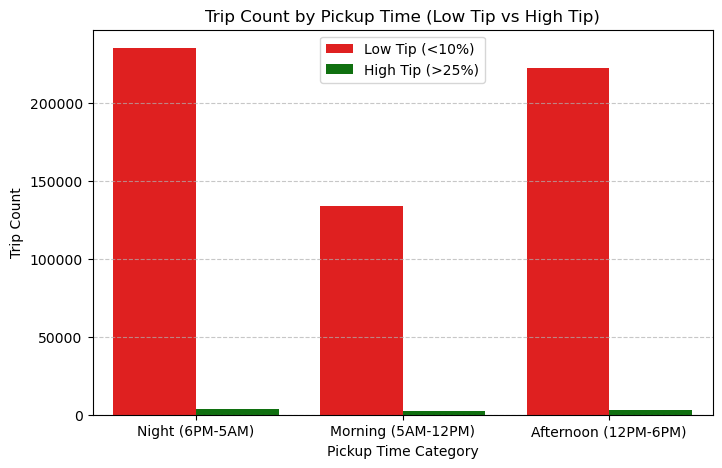

In [102]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_filtered[df_filtered["tip_category"].isin(["Low Tip (<10%)", "High Tip (>25%)"])], 
              x="pickup_time_category", hue="tip_category", palette={"Low Tip (<10%)": "red", "High Tip (>25%)": "green"})
plt.xlabel("Pickup Time Category")
plt.ylabel("Trip Count")
plt.title("Trip Count by Pickup Time (Low Tip vs High Tip)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


📊 Insights from the Comparison </br>
Trip Distance & Tip % </br>
</br>
Do short trips get fewer tips? </br>
Do longer trips receive better tips? </br>
Passenger Count & Tip % </br>
</br>
Do solo passengers tip better than groups? </br>
Are large groups less likely to tip high? </br>
Pickup Time & Tip % </br>
</br>
Are night trips tipping less?</br>
Are morning trips receiving better tips?</br>

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

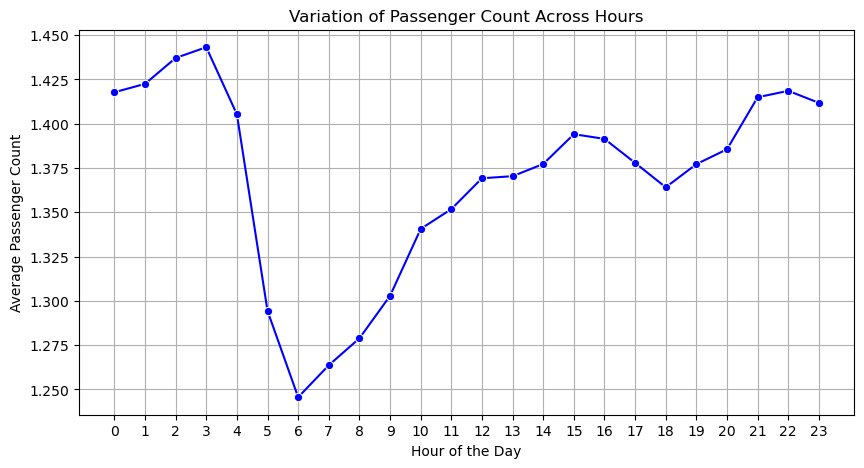

In [103]:
# See how passenger count varies across hours and days


# Group by hour and calculate average passenger count
hourly_passenger_count = merged_gdf_insights.groupby("hour")["passenger_count"].mean()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_passenger_count.index, y=hourly_passenger_count.values, marker="o", color="blue")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Passenger Count")
plt.title("Variation of Passenger Count Across Hours")
plt.xticks(range(0, 24))
plt.grid()
plt.show()




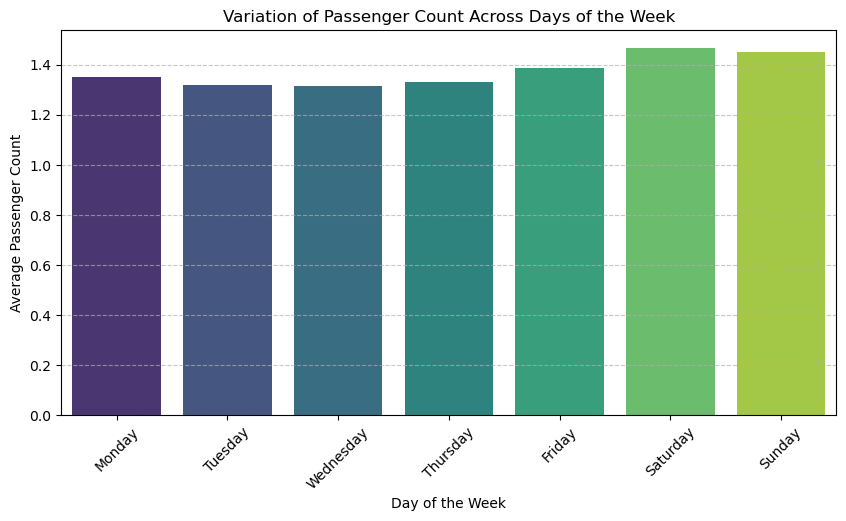

In [104]:
# Group by day of the week
daily_passenger_count = merged_gdf_insights.groupby("day_of_week")["passenger_count"].mean()

# Days mapping
days_mapping = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 
                4: "Friday", 5: "Saturday", 6: "Sunday"}
daily_passenger_count.index = daily_passenger_count.index.map(days_mapping)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=daily_passenger_count.index, y=daily_passenger_count.values, palette="viridis")
plt.xlabel("Day of the Week")
plt.ylabel("Average Passenger Count")
plt.title("Variation of Passenger Count Across Days of the Week")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


🔍 Insights to Look For </br>
Peak Hours: Identify when the highest number of passengers travel. </br>
Weekday vs. Weekend Trends: Do weekends have more passengers? </br>
Time of Day Variation: Are evenings or mornings busier? </br>

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [105]:
# How does passenger count vary across zones


# Group by pickup zones & calculate total & average passenger count
zone_passenger_counts = merged_gdf_insights.groupby("zone")["passenger_count"].agg(["sum", "mean"]).reset_index()

# Sort zones by total passenger count
top_zones = zone_passenger_counts.sort_values(by="sum", ascending=False)

# Display the top 10 zones with the highest passenger count
print(top_zones.head(10))



                             zone       sum      mean
115                   JFK Airport  141279.0  1.488025
148                Midtown Center  117405.0  1.375249
222         Upper East Side South  114560.0  1.325159
221         Upper East Side North  102249.0  1.326410
215     Times Sq/Theatre District   89780.0  1.478980
125             LaGuardia Airport   86217.0  1.353761
149                  Midtown East   86027.0  1.319655
173  Penn Station/Madison Sq West   83908.0  1.332317
129           Lincoln Square East   82821.0  1.369599
150                 Midtown North   73828.0  1.382728


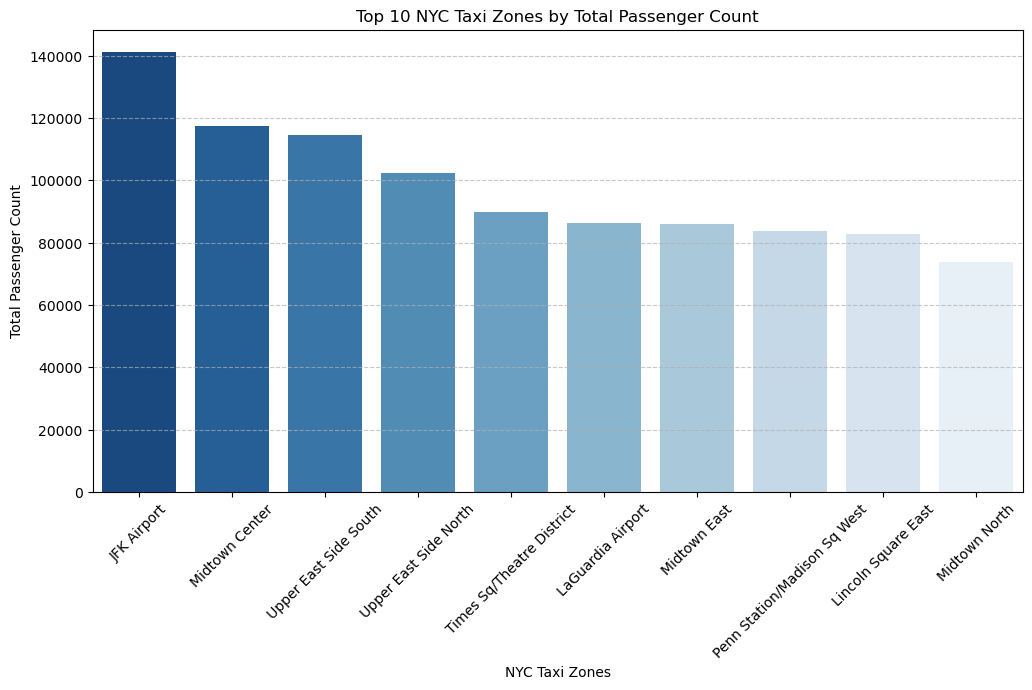

In [106]:
# Plot bar chart for top 10 zones by total passenger count
plt.figure(figsize=(12, 6))
sns.barplot(x=top_zones["zone"][:10], y=top_zones["sum"][:10], palette="Blues_r")
plt.xlabel("NYC Taxi Zones")
plt.ylabel("Total Passenger Count")
plt.title("Top 10 NYC Taxi Zones by Total Passenger Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


🔍 Insights to Look For </br>
Which zones have the highest & lowest passenger counts? </br>
Are busy zones concentrated in Manhattan, Queens, or Brooklyn? </br>
Do zones near airports or business districts have higher passenger volumes? </br>

In [107]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

# Group by zone and calculate the average passenger count
avg_passenger_per_zone = merged_gdf_insights.groupby("zone")["passenger_count"].mean().reset_index()

# Rename column for clarity
avg_passenger_per_zone.rename(columns={"passenger_count": "avg_passenger_count"}, inplace=True)

# List of surcharge columns
surcharge_columns = ["extra", "congestion_surcharge", "airport_fee", "improvement_surcharge"]

# Calculate the percentage of trips where each surcharge is applied
surcharge_prevalence = merged_gdf_insights[surcharge_columns].apply(lambda x: (x > 0).mean() * 100)

# Convert to DataFrame for better visualization
surcharge_prevalence_df = surcharge_prevalence.reset_index()
surcharge_prevalence_df.columns = ["Surcharge Type", "Prevalence (%)"]


Find out how often surcharges/extra charges are applied to understand their prevalance

In [108]:
print(surcharge_prevalence_df)

          Surcharge Type  Prevalence (%)
0                  extra       62.642405
1   congestion_surcharge       93.407274
2            airport_fee        8.828400
3  improvement_surcharge       99.998165


**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [109]:
# How often is each surcharge applied?

# We group by pickup zones (PULocationID) and dropoff zones (DOLocationID) to see where surcharges are most commonly applied.

# List of surcharge columns
surcharge_columns = ["extra", "congestion_surcharge", "airport_fee", "improvement_surcharge"]

# Calculate the percentage of trips where each surcharge is applied per pickup zone
pickup_surcharge = merged_gdf_insights.groupby("PULocationID")[surcharge_columns].apply(lambda x: (x > 0).mean() * 100)

# Calculate the percentage of trips where each surcharge is applied per dropoff zone
dropoff_surcharge = merged_gdf_insights.groupby("DOLocationID")[surcharge_columns].apply(lambda x: (x > 0).mean() * 100)

# Reset index for easier handling
pickup_surcharge = pickup_surcharge.reset_index()
dropoff_surcharge = dropoff_surcharge.reset_index()


In [110]:
# Find top pickup zones where surcharges are most frequently applied
top_pickup_surcharge_zones = pickup_surcharge.sort_values(by="extra", ascending=False).head(10)

# Find top dropoff zones where surcharges are most frequently applied
top_dropoff_surcharge_zones = dropoff_surcharge.sort_values(by="extra", ascending=False).head(10)

print("Top Pickup Zones with High Extra Charges:\n", top_pickup_surcharge_zones)
print("Top Dropoff Zones with High Extra Charges:\n", top_dropoff_surcharge_zones)


Top Pickup Zones with High Extra Charges:
      PULocationID  extra  congestion_surcharge  airport_fee  \
189           201  100.0                   0.0          0.0   
111           122  100.0                   0.0          0.0   
115           126  100.0                  40.0          0.0   
106           117  100.0                   0.0          0.0   
55             59  100.0                 100.0          0.0   
42             46  100.0                 100.0          0.0   
166           178  100.0                   0.0          0.0   
28             32  100.0                   0.0          0.0   
175           187  100.0                 100.0          0.0   
187           199  100.0                  50.0          0.0   

     improvement_surcharge  
189                  100.0  
111                  100.0  
115                  100.0  
106                  100.0  
55                   100.0  
42                   100.0  
166                  100.0  
28                   100.0  
17

In [111]:
# Group by hour of the day and calculate percentage of trips with surcharges
hourly_surcharge = merged_gdf_insights.groupby("hour")[surcharge_columns].apply(lambda x: (x > 0).mean() * 100).reset_index()

print(hourly_surcharge)


    hour      extra  congestion_surcharge  airport_fee  improvement_surcharge
0      0  96.612858             91.238647    10.690913             100.000000
1      1  97.649503             93.352129     6.098828              99.997032
2      2  98.439973             95.057653     3.196925             100.000000
3      3  97.748501             94.521121     2.830057             100.000000
4      4  94.146122             91.568164     3.793763              99.988743
5      5  89.185723             84.815131    11.925625             100.000000
6      6  33.744031             87.457367    12.589529             100.000000
7      7  30.935448             91.918938     7.898546              99.991608
8      8  30.845159             93.737062     6.547958              99.997000
9      9  31.663437             93.942806     7.432043              99.994762
10    10  31.970282             94.045725     8.012011              99.998804
11    11  31.314566             94.728959     7.167559          

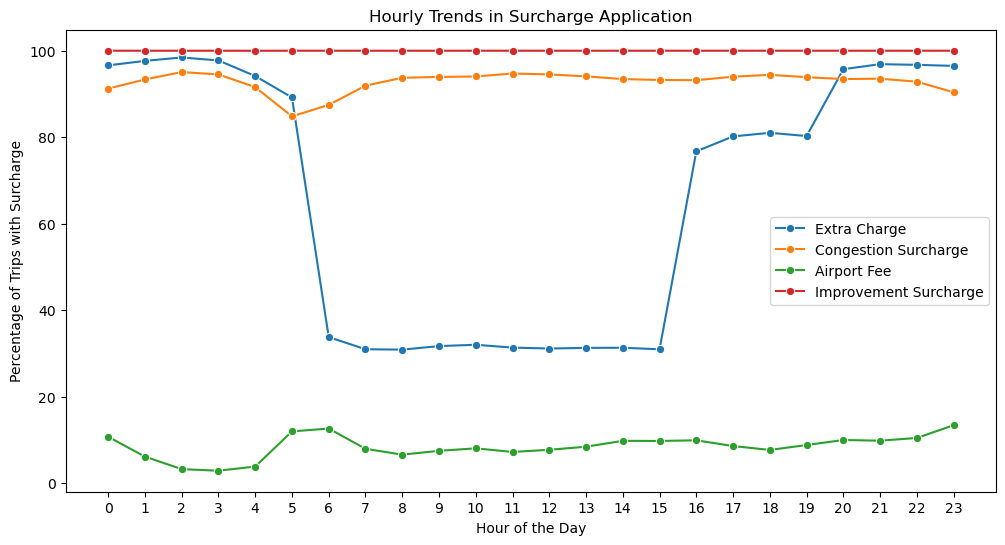

In [112]:


plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_surcharge, x="hour", y="extra", label="Extra Charge", marker="o")
sns.lineplot(data=hourly_surcharge, x="hour", y="congestion_surcharge", label="Congestion Surcharge", marker="o")
sns.lineplot(data=hourly_surcharge, x="hour", y="airport_fee", label="Airport Fee", marker="o")
sns.lineplot(data=hourly_surcharge, x="hour", y="improvement_surcharge", label="Improvement Surcharge", marker="o")

plt.title("Hourly Trends in Surcharge Application")
plt.xlabel("Hour of the Day")
plt.ylabel("Percentage of Trips with Surcharge")
plt.xticks(range(0, 24))
plt.legend()
plt.show()


🔍 Insights to Look For </br> 
Which zones have the highest surcharges? (e.g., airport locations might have high airport_fee) </br>
Which times have the most extra charges? (extra may be higher at night due to late-night surcharges) </br>
Does congestion surcharge peak at rush hours? (likely higher in mornings/evenings) </br>
Are airport fees mostly at certain times? (e.g., early mornings for flights) </br>

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

•	Increase morning fleet allocation in residential areas. </br>
•	Reduce idle taxis in Midtown during peak hours (to avoid congestion slowdowns). </br>
•	Nighttime fleet allocation should focus on nightlife hubs and airports. </br>

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

•	Prioritize high pickup zones (JFK, Times Square, Penn Station) during peak hours. </br>
•	Encourage longer trips to maximize revenue (e.g., JFK to Midtown rides). </br>
•	Use geo-fencing to pre-position taxis based on predictive demand data. </br>
•	Reduce congestion surcharge in tourist-heavy zones on weekends to encourage travel. </br>
•	Increase airport surcharges during peak travel days to reflect increased demand. </br>



**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

•	Implement dynamic fare pricing for short-distance trips to encourage ridership. </br> 
•	Introduce off-peak discounts for midday rides in less busy areas. </br> 
•	Adjust airport pricing tiers to better reflect congestion impact. </br> 
•	Offer discounts on shared rides to improve affordability. </br> 
•	Highlight top tipping zones & times to drivers to boost earnings. </br> 
